In [1]:
import os, json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import random
import fsspec
import gcsfs
import io

from mplsoccer import Pitch

import umap
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

In [2]:
pd.set_option('display.max_columns', None)

In [29]:
BUCKET_NAME = "arthur_tmp"
BASE_GCS_PATH = f"gs://{BUCKET_NAME}"

DYNAMIC_DIR = f"{BASE_GCS_PATH}/dynamic"
META_DIR = f"{BASE_GCS_PATH}/meta"
TRACKING_DIR = f"{BASE_GCS_PATH}/tracking"
POSSESSION_DIR = f"{BASE_GCS_PATH}/possession"
PITCH_CONTROL_DIR = f"{BASE_GCS_PATH}/pitch_control"
CLUSTERING_DIR = f"{BUCKET_NAME}/clustering"
SOCCERMAP_FRAMES_DIR3 = f"{BASE_GCS_PATH}/soccermap_frames_DIR3"
SOCCERMAP_MODELS_DIR = f"{BUCKET_NAME}/soccermap_model"

# Pitch constants (SkillCorner → 105x68, origin at left-bottom after rescale)
X_MIN, X_MAX = -52, 52
Y_MIN, Y_MAX = -34, 34
PITCH_LENGTH, PITCH_WIDTH = 105.0, 68.0

In [4]:
fs = gcsfs.GCSFileSystem()

# Prepare inputs

In [115]:
def prepare_clustering_features():
    """
    Transforme la liste de dictionnaires en matrice de features pour le clustering.
    Lit les informations contextuelles (player, équipe, minute, etc.)
    directement depuis le fichier POSSESSION_DIR/<match_id>.parquet.

    Les frames contenant des NaN dans 'player_position', 
    'distance_to_nearest_teammate' ou 'distance_to_nearest_opponent' 
    sont exclues des résultats.

    Colonnes ajoutées dans meta :
        - match_id
        - player_id
        - player_name
        - player_team
        - opponent_team
        - minute
    """

    fs = gcsfs.GCSFileSystem()
    feature_vectors = []
    meta_info = []
    frames_inputs = []

    pitch_control_files = fs.glob(f"{PITCH_CONTROL_DIR}/*.npz")
    if not pitch_control_files:
        print(f"⚠️ Aucun fichier trouvé dans {PITCH_CONTROL_DIR}")
        return None, None, None

    for gcs_path in tqdm(sorted(pitch_control_files)):
        match_id = gcs_path.split("/")[-1].replace(".npz", "")

        # --- Lecture du fichier .npz ---
        try:
            with fs.open(gcs_path, "rb") as f:
                data = np.load(f, allow_pickle=True)
                results = data["results"].tolist()
        except Exception as e:
            print(f"⚠️ Erreur lecture {gcs_path} : {e}")
            continue

        if not results:
            continue

        # --- Lecture du fichier POSSESSION correspondant ---
        possession_path = f"{POSSESSION_DIR}/{match_id}.parquet"
        try:
            with fs.open(possession_path, "rb") as fp:
                possession_df = pd.read_parquet(fp)
        except Exception as e:
            print(f"⚠️ Impossible de lire {possession_path} : {e}")
            possession_df = None

        # --- Préparer les noms d'équipes (pour déduction adversaire) ---
        all_teams = (
            possession_df["team_name"].unique().tolist()
            if possession_df is not None and "team_name" in possession_df.columns
            else []
        )

        # --- Itération sur les résultats valides ---
        for item in results:
            # Exclusion si NaN critiques
            player_position = item.get("player_position", (np.nan, np.nan))
            if (
                np.isnan(player_position[0]) or np.isnan(player_position[1]) or
                np.isnan(item.get("distance_to_nearest_teammate", np.nan)) or
                np.isnan(item.get("distance_to_nearest_opponent", np.nan))
            ):
                continue  # on ignore cette frame

            player_id = item.get("player_id")
            frame = item.get("frame")

            # (1) Flatten de la carte de Pitch Control
            pitch_flat = item["pitch_control_map"].flatten()
            
            # remove outliers
            #count_gt_0 = np.sum(pitch_flat > 0)
            count_gt_05 = np.sum(pitch_flat > 0.5)
            #if count_gt_0 > 750 or count_gt_05 > 70:
            if count_gt_05 > 70:
                continue

            # (2) Features contextuelles
            defensive_lines = np.array(item["defensive_lines"], dtype=float)
            defensive_lines = np.pad(
                defensive_lines, (0, 3 - len(defensive_lines)),
                mode='constant', constant_values=np.nan
            )

            ball_x, ball_y = item["ball_position"]
            in_possession = 1.0 if item["in_possession"] else 0.0

            context_features = np.array([
                *defensive_lines,
                ball_x,
                ball_y,
                in_possession,
                item["distance_to_ball"],
                item["distance_to_nearest_teammate"],
                item["distance_to_nearest_opponent"]
            ], dtype=float)

            full_vector = np.concatenate([pitch_flat, context_features])
            feature_vectors.append(full_vector)
            frames_inputs.append(item)

            # (3) Récupération des infos depuis le parquet possession
            if possession_df is not None:
                row = possession_df[
                    (possession_df["frame"] == frame) &
                    (possession_df["player_id"] == player_id)
                ]
                if not row.empty:
                    row = row.iloc[0]
                    player_name = row.get("player_short_name", None)
                    player_team = row.get("team_name", None)
                    minute = None
                    time_val = row.get("time", None)
                    if isinstance(time_val, str) and len(time_val) >= 5:
                        try:
                            minute = int(time_val.split(":")[1])
                        except Exception:
                            minute = None

                    # Déduire l’adversaire
                    opponent_team = None
                    if all_teams and player_team in all_teams:
                        opponent_team = [t for t in all_teams if t != player_team]
                        opponent_team = opponent_team[0] if opponent_team else None
                else:
                    player_name = None
                    player_team = None
                    opponent_team = None
                    minute = None
            else:
                player_name = None
                player_team = None
                opponent_team = None
                minute = None

            # (4) Ajouter au meta_info
            meta_info.append({
                "match_id": match_id,
                "frame": frame,
                "player_id": player_id,
                "player_position_role": item.get("player_position_role", None),
                "player_name": player_name,
                "player_team": player_team,
                "opponent_team": opponent_team,
                "minute": minute
            })

    if not feature_vectors:
        print("⚠️ Aucun vecteur de features généré (fichiers vides ?)")
        return None, None, None

    # --- Matrice finale des features ---
    X = np.vstack(feature_vectors)

    # --- Gestion des NaN restants (remplacés par moyenne colonne) ---
    nan_mask = np.isnan(X)
    if np.any(nan_mask):
        col_means = np.nanmean(X, axis=0)
        inds = np.where(nan_mask)
        X[inds] = np.take(col_means, inds[1])

    meta = pd.DataFrame(meta_info)
    return X, meta, frames_inputs

In [116]:
%%time

X, meta, frames_inputs = prepare_clustering_features()

100%|██████████| 378/378 [07:15<00:00,  1.15s/it]


CPU times: user 50.7 s, sys: 4.25 s, total: 54.9 s
Wall time: 7min 17s


In [117]:
fs = gcsfs.GCSFileSystem()
fs.mkdirs(CLUSTERING_DIR, exist_ok=True)

X_path = f"{CLUSTERING_DIR}/X_features_center_forward_wo_outliers.npz"
with fs.open(X_path, "wb") as f:
    np.savez_compressed(f, X=X)

print(f"✅ Matrice X sauvegardée sur GCS : {X_path} (shape={X.shape})")

✅ Matrice X sauvegardée sur GCS : arthur_tmp/clustering/X_features_center_forward_wo_outliers.npz (shape=(62856, 1609))


In [118]:
meta_path = f"{CLUSTERING_DIR}/meta_frames_center_forward_wo_outliers.parquet"
with fs.open(meta_path, "wb") as f:
    meta.to_parquet(f, index=False)
    
print(f"✅ DataFrame meta sauvegardé sur GCS : {meta_path} (shape={meta.shape})")

✅ DataFrame meta sauvegardé sur GCS : arthur_tmp/clustering/meta_frames_center_forward_wo_outliers.parquet (shape=(62856, 8))


# Test cells

In [129]:
X_sub = X[:, :1600]
non_zero_counts = np.count_nonzero(X_sub, axis=1)
counts_gt_05 = np.sum(X_sub > 0.5, axis=1)
counts_gt_02= np.sum(X_sub > 0.2, axis=1)
average_gt_05 = counts_gt_05.mean()
average_non_zero = non_zero_counts.mean()
average_non_zero

646.4399579992363

In [127]:
average_non_zero

646.4399579992363

(array([1.460e+02, 1.891e+03, 4.386e+03, 7.561e+03, 7.572e+03, 8.213e+03,
        6.288e+03, 6.149e+03, 4.120e+03, 3.460e+03, 2.449e+03, 2.095e+03,
        1.618e+03, 1.088e+03, 9.450e+02, 7.560e+02, 7.030e+02, 5.000e+02,
        4.610e+02, 3.490e+02, 3.270e+02, 2.600e+02, 2.330e+02, 1.810e+02,
        1.500e+02, 1.360e+02, 1.000e+02, 1.140e+02, 8.700e+01, 9.900e+01,
        6.400e+01, 6.900e+01, 3.800e+01, 4.800e+01, 3.500e+01, 3.100e+01,
        3.000e+01, 2.300e+01, 1.800e+01, 1.100e+01, 1.100e+01, 9.000e+00,
        5.000e+00, 8.000e+00, 5.000e+00, 4.000e+00, 4.000e+00, 3.000e+00,
        1.000e+00, 2.000e+00]),
 array([  0.  ,   7.54,  15.08,  22.62,  30.16,  37.7 ,  45.24,  52.78,
         60.32,  67.86,  75.4 ,  82.94,  90.48,  98.02, 105.56, 113.1 ,
        120.64, 128.18, 135.72, 143.26, 150.8 , 158.34, 165.88, 173.42,
        180.96, 188.5 , 196.04, 203.58, 211.12, 218.66, 226.2 , 233.74,
        241.28, 248.82, 256.36, 263.9 , 271.44, 278.98, 286.52, 294.06,
        301.6 , 

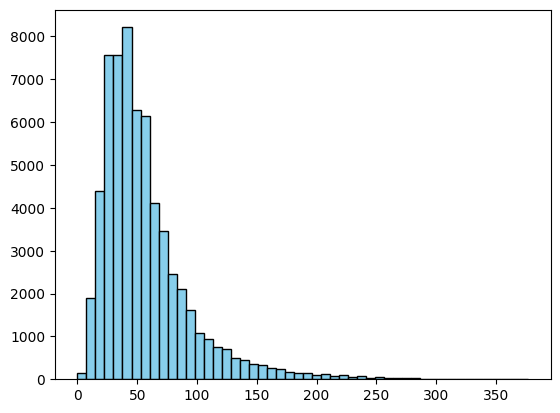

In [130]:
plt.hist(counts_gt_02, bins=50, color='skyblue', edgecolor='black')

In [6]:
meta

,match_id,frame,player_id,player_position_role,player_name,player_team,opponent_team,minute
0,1650385,1625,1498,Center Forward,Bruno Fernandes,Manchester United,Fulham,2
1,1650385,1648,1498,Center Forward,Bruno Fernandes,Manchester United,Fulham,2
2,1650385,1692,1498,Center Forward,Bruno Fernandes,Manchester United,Fulham,2
3,1650385,1699,1498,Center Forward,Bruno Fernandes,Manchester United,Fulham,2
4,1650385,1728,1498,Center Forward,Bruno Fernandes,Manchester United,Fulham,2
...,...,...,...,...,...,...,...,...
78860,2018580,54746,13368,Center Forward,Y. Wissa,Brentford FC,Wolverhampton Wanderers,29
78861,2018580,56507,13368,Center Forward,Y. Wissa,Brentford FC,Wolverhampton Wanderers,32
78862,2018580,56545,13368,Center Forward,Y. Wissa,Brentford FC,Wolverhampton Wanderers,32
78863,2018580,56572,13368,Center Forward,Y. Wissa,Brentford FC,Wolverhampton Wanderers,32


In [8]:
meta.player_name.value_counts()

player_name
E. Haaland        7071
R. Jiménez        3689
A. Isak           3526
D. Solanke        3282
N. Jackson        3143
                  ... 
C. Jones            42
E. Smith Rowe       37
M. Gibbs-White      26
E. Ferguson         22
A. Grønbæk          20
Name: count, Length: 87, dtype: int64

In [6]:
with fs.open("arthur_tmp/pitch_control/1650961.npz", "rb") as f:
    data = np.load(f, allow_pickle=True)
    results = data["results"].tolist()

In [7]:
frame = results[0]

In [8]:
frame

{'pitch_control_map': array([[0.        , 0.        , 0.        , ..., 0.2457436 , 0.21857936,
         0.19213628],
        [0.        , 0.        , 0.        , ..., 0.17841331, 0.14609492,
         0.12367451],
        [0.        , 0.        , 0.        , ..., 0.09829216, 0.08602993,
         0.09908822],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 'defensive_lines': [58.736899038461544, 72.58125, 90.01326923076924],
 'frame': 1090,
 'player_id': 32125,
 'player_position': (83.27307692307693, 10.2),
 'ball_position': (91.19855769230769, 23.42),
 'in_possession': False,
 'distance_to_ball': 15.41368370713006,
 'distance_to_nearest_teammate': 3.6598626780912507,
 'distance_to_nearest_opponent': 3.6616335649918814,
 'player_positio

In [9]:
frame['pitch_control_map'].shape

(32, 50)

In [139]:
arr = frame['pitch_control_map'].flatten()

In [140]:
np.count_nonzero(arr)

527

In [141]:
np.sum(arr > 0.5)

94

In [14]:
len(frames_inputs)

73120

In [15]:
frames_inputs[0]

{'pitch_control_map': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'defensive_lines': [60.455769230769235, 71.61605769230769, 82.43762019230769],
 'frame': 1625,
 'player_id': 1498,
 'player_position': (77.88173076923077, 50.82),
 'ball_position': (68.65384615384616, 57.5),
 'in_possession': False,
 'distance_to_ball': 11.391938135139778,
 'distance_to_nearest_teammate': 10.26718897565972,
 'distance_to_nearest_opponent': 5.084613021681336,
 'player_position_role': 'Center Forward'}

# Clustering

## PCA - UMAP - HDBSCAN

In [21]:
%%time

# 1. Standardisation
X_scaled = StandardScaler().fit_transform(X)

# 2. PCA pour compresser à 50 dimensions
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 3. UMAP sur PCA
reducer = umap.UMAP(
    n_neighbors=100,   # structure locale
    min_dist=0.2,     # densité de projection
    n_components=20,   # pour clustering
    random_state=42
)
embedding = reducer.fit_transform(X_pca)

# 4. HDBSCAN
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=3000,
    min_samples=30,
    cluster_selection_epsilon=0.05,
    cluster_selection_method='leaf'
).fit(embedding)

labels = clusterer.labels_
n_clusters = len(set(labels[labels >= 0]))
print("clusters:", n_clusters, "noise:", np.sum(labels==-1))

IOStream.flush timed out
/opt/conda/envs/pitch-control/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/envs/pitch-control/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


clusters: 3 noise: 56861
CPU times: user 20min 5s, sys: 48.4 s, total: 20min 54s
Wall time: 14min 7s


## PCA - KMEANS

In [268]:
def plot_elbow_method(X, max_clusters=10, sample_size=20000, n_components=50, n_spatial_features=1600, random_state=42):
    """
    Applique la méthode du coude (Elbow Method) sur les données X.
    - Fait un sous-échantillonnage si X est trop grand pour accélérer le calcul.
    - Retourne la liste des inerties (somme des distances intra-cluster).

    Paramètres
    ----------
    X : np.ndarray
        Matrice des features (n_samples, n_features)
    max_clusters : int
        Nombre maximal de clusters à tester.
    sample_size : int
        Nombre de points à utiliser pour la méthode (utile pour éviter un calcul trop long).
    random_state : int
        Pour la reproductibilité.
    """

    # --- Sous-échantillonnage pour accélérer ---
    if X.shape[0] > sample_size:
        np.random.seed(random_state)
        idx = np.random.choice(X.shape[0], sample_size, replace=False)
        X_sample = X[idx]
        print(f"➡️ Sous-échantillonnage à {sample_size} échantillons (sur {X.shape[0]}).")
    else:
        X_sample = X
        
    # apply PCA only on spatial features
    # --- Séparation des features ---
    X_spatial = X[:, :n_spatial_features]
    X_context = X[:, n_spatial_features:]

    print(f"🌍 Partie spatiale : {X_spatial.shape}, 🧩 Partie contextuelle : {X_context.shape}")

    # --- Standardisation ---
    scaler_spatial = StandardScaler()
    X_spatial_scaled = scaler_spatial.fit_transform(X_spatial)

    # --- PCA uniquement sur la partie spatiale ---
    pca = PCA(n_components=n_components, random_state=random_state)
    X_spatial_pca = pca.fit_transform(X_spatial_scaled)

    explained_var = np.sum(pca.explained_variance_ratio_) * 100
    print(f"✅ PCA sur la partie spatiale : {n_components} composantes (explained variance = {explained_var:.1f}%)")

    # --- Standardiser les features contextuelles (elles aussi importantes) ---
    scaler_context = StandardScaler()
    X_context_scaled = scaler_context.fit_transform(X_context)

    # --- Fusion finale ---
    X_reduced = np.concatenate([X_spatial_pca, X_context_scaled], axis=1)
    print(f"✅ Dimensions finales : {X_reduced.shape}")
    

#    # --- Standardisation ---
#    scaler = StandardScaler()
#    X_scaled = scaler.fit_transform(X_sample)
#    
#    # --- PCA ---
#    print(f"⚙️ Réduction PCA à {n_components} composantes...")
#    pca = PCA(n_components=n_components, random_state=random_state)
#    X_reduced = pca.fit_transform(X_scaled)
#
#    explained_var = np.sum(pca.explained_variance_ratio_) * 100
#    print(f"✅ PCA conserve {explained_var:.1f}% de la variance totale")

    # --- Calcul des inerties pour différents K ---
    inertias = []
    Ks = range(1, max_clusters + 1)

    for k in tqdm(Ks, desc="Calcul du coude KMeans"):
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init="auto")
        kmeans.fit(X_reduced)
        inertias.append(kmeans.inertia_)

    # --- Plot du coude ---
    plt.figure(figsize=(8, 5))
    plt.plot(Ks, inertias, "o-", linewidth=2, color="royalblue")
    plt.title("(Elbow Method)")
    plt.xlabel("Number of clusters")
    plt.ylabel("Intra-cluster inertia")
    plt.xticks(Ks)
    plt.grid(True)
    plt.show()

    return Ks, inertias

🌍 Partie spatiale : (62856, 1600), 🧩 Partie contextuelle : (62856, 9)
✅ PCA sur la partie spatiale : 50 composantes (explained variance = 86.2%)
✅ Dimensions finales : (62856, 59)


Calcul du coude KMeans: 100%|██████████| 20/20 [00:07<00:00,  2.69it/s]


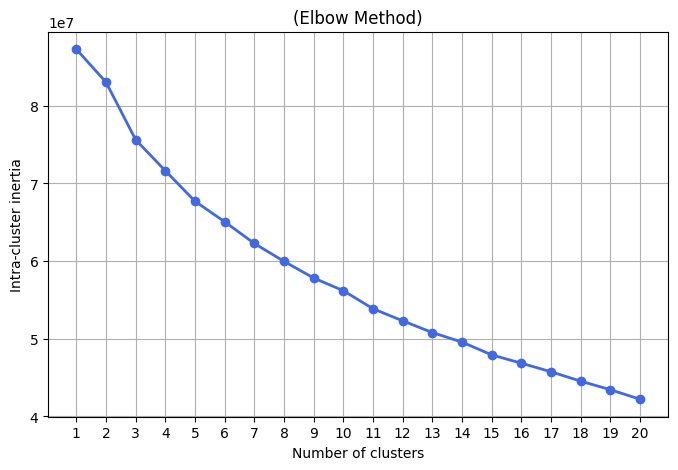

In [269]:
Ks, inertias = plot_elbow_method(X, max_clusters=20, sample_size=10000000)

In [148]:
n_components = 50

# apply PCA only on spatial features
# --- Séparation des features ---
X_spatial = X[:, :1600]
X_context = X[:, 1600:]

print(f"🌍 Partie spatiale : {X_spatial.shape}, 🧩 Partie contextuelle : {X_context.shape}")

# --- Standardisation ---
scaler_spatial = StandardScaler()
X_spatial_scaled = scaler_spatial.fit_transform(X_spatial)

# --- PCA uniquement sur la partie spatiale ---
pca = PCA(n_components=n_components, random_state=42)
X_spatial_pca = pca.fit_transform(X_spatial_scaled)

explained_var = np.sum(pca.explained_variance_ratio_) * 100
print(f"✅ PCA sur la partie spatiale : {n_components} composantes (explained variance = {explained_var:.1f}%)")

# --- Standardiser les features contextuelles (elles aussi importantes) ---
scaler_context = StandardScaler()
X_context_scaled = scaler_context.fit_transform(X_context)

# --- Fusion finale ---
X_reduced = np.concatenate([X_spatial_pca, X_context_scaled], axis=1)
print(f"✅ Dimensions finales : {X_reduced.shape}")

#X_scaled = StandardScaler().fit_transform(X)
#reducer = PCA(n_components=50, random_state=42)
#X_reduced = reducer.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=11, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_reduced)

🌍 Partie spatiale : (62856, 1600), 🧩 Partie contextuelle : (62856, 9)
✅ PCA sur la partie spatiale : 50 composantes (explained variance = 86.2%)
✅ Dimensions finales : (62856, 59)


In [150]:
len(set(labels)) - (1 if -1 in labels else 0)  # nombre de clusters (excluant le bruit)

11

In [151]:
meta["cluster"] = labels

In [152]:
def plot_cluster_summary_pitch_control_with_pitch(
    results,
    meta,
    n_cols=3,
    pitch_length=105,
    pitch_width=68,
    half_pitch=True
):
    """
    Affiche la carte moyenne de pitch control et les features contextuelles moyennes par cluster.
    """

    # Clusters valides (on exclut les outliers HDBSCAN = -1)
    unique_clusters = sorted([c for c in meta["cluster"].unique() if c != -1])
    if len(unique_clusters) == 0:
        print("Aucun cluster valide (hors -1) trouvé dans meta['cluster'].")
        return

    n_clusters = len(unique_clusters)
    n_rows = int(np.ceil(n_clusters / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows))
    axes = axes.flatten()

    cmap = plt.cm.RdBu_r
    cmap.set_bad(color="white")

    pcm = None  # utilisé pour la colorbar globale

    for i, cluster_id in enumerate(unique_clusters):
        ax = axes[i]

        # ---- Extraire les éléments du cluster ----
        cluster_indices = meta.index[meta["cluster"] == cluster_id].tolist()
        cluster_items = [results[idx] for idx in cluster_indices]

        if len(cluster_items) == 0:
            ax.axis("off")
            continue

        # ---- Moyenne des cartes de pitch control (ignorer NaN) ----
        maps = np.array([item["pitch_control_map"] for item in cluster_items])
        # maps shape = (n_frames, H, W)
        mean_map = np.nanmean(maps, axis=0)  # si certains éléments contiennent NaN, on les ignore

        # ---- Moyenne des lignes défensives ----
        # On s'assure que chaque defensive_lines est un array de longueur 3 (avec NaN si manquant)
        def_lines_list = []
        for item in cluster_items:
            lines = np.array(item.get("defensive_lines", []), dtype=float)
            if lines.size == 0:
                padded = np.array([np.nan, np.nan, np.nan])
            else:
                padded = np.pad(lines, (0, max(0, 3 - len(lines))), mode="constant", constant_values=np.nan)
            def_lines_list.append(padded)
        all_lines = np.vstack(def_lines_list)  # shape (n_frames, 3)
        mean_lines = np.nanmean(all_lines, axis=0)  # résultat shape (3,)
        # si toutes les valeurs d'une colonne sont NaN, np.nanmean renvoie nan -> on détecte ensuite

        # ---- Moyennes des features contextuelles (ignorer NaN) ----
        # utils : colonne peut contenir NaN
        def nanmean_safe(lst):
            arr = np.array(lst, dtype=float)
            if np.all(np.isnan(arr)):
                return np.nan
            return float(np.nanmean(arr))

        mean_dist_ball = nanmean_safe([item.get("distance_to_ball", np.nan) for item in cluster_items])
        mean_dist_tm = nanmean_safe([item.get("distance_to_nearest_teammate", np.nan) for item in cluster_items])
        mean_dist_op = nanmean_safe([item.get("distance_to_nearest_opponent", np.nan) for item in cluster_items])

        # ---- Possession ratio & nombre de frames ----
        in_poss_array = np.array([1.0 if item.get("in_possession", False) else 0.0 for item in cluster_items], dtype=float)
        possession_ratio = float(np.nanmean(in_poss_array)) if in_poss_array.size > 0 else np.nan
        n_frames = len(cluster_items)

        # ---- Création du pitch + grille ----
        pitch = Pitch(
            pitch_type="custom",
            pitch_length=pitch_length,
            pitch_width=pitch_width,
            line_color="black",
            pitch_color="white"
        )

        H, W = mean_map.shape
        x = np.linspace(0, pitch_length, W)
        y = np.linspace(0, pitch_width, H)
        bin_statistic = dict(statistic=mean_map, x_grid=x, y_grid=y)

        # ---- Plot de la heatmap (utilise mean_map, NaN seront affichés en blanc grâce à cmap.set_bad) ----
        pitch.draw(ax=ax)
        pcm = pitch.heatmap(
            bin_statistic,
            ax=ax,
            cmap=cmap,
            vmin=0,
            vmax=1,
            alpha=0.9,
        )

        if half_pitch:
            ax.set_xlim(pitch_length / 2, pitch_length)
            ax.set_ylim(0, pitch_width)

        # ---- Lignes défensives : ne tracer que les composantes non-NaN ----
        if mean_lines.size > 0 and not np.all(np.isnan(mean_lines)):
            colors = ["black", "gray", "silver"]
            for j, x_mean in enumerate(mean_lines):
                if not np.isnan(x_mean):
                    ax.axvline(x=float(x_mean), color=colors[j % len(colors)], linestyle="--", linewidth=2)

        # ---- Titres & annotations ----
        # formatage des moyennes en remplaçant nan par 'n/a'
        def fmt(v):
            return f"{v:.2f}" if (v is not None and not np.isnan(v)) else "n/a"

        stats_text = (
            f"Frames: {n_frames}  |  Possession: {possession_ratio:.0%}\n"
            f"Dist. Ballon: {fmt(mean_dist_ball)} m  |  "
            f"Dist. Coéquipier: {fmt(mean_dist_tm)} m  |  "
            f"Dist. Adversaire: {fmt(mean_dist_op)} m"
        )

        ax.set_title(f"Cluster {cluster_id}", fontsize=13, fontweight="bold")
        ax.text(0.5, -0.08, stats_text, transform=ax.transAxes, fontsize=10, ha="center", va="top")

    # ---- Supprimer les axes vides (derniers) ----
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    # ---- Ajustement des marges pour éviter le chevauchement ----
    plt.subplots_adjust(right=0.92, wspace=0.35, hspace=0.45)

    # ---- Barre de couleur globale (placée à droite, hors de la zone des subplots) ----
    if pcm is not None:
        cbar_ax = fig.add_axes([0.94, 0.25, 0.02, 0.5])  # [left, bottom, width, height] en fraction de la fig
        cbar = fig.colorbar(pcm, cax=cbar_ax)
        cbar.set_label("Mean Pitch Control Probability", fontsize=11)

    fig.suptitle("Cartes moyennes de Pitch Control par Cluster", fontsize=18, fontweight="bold")
    plt.show()

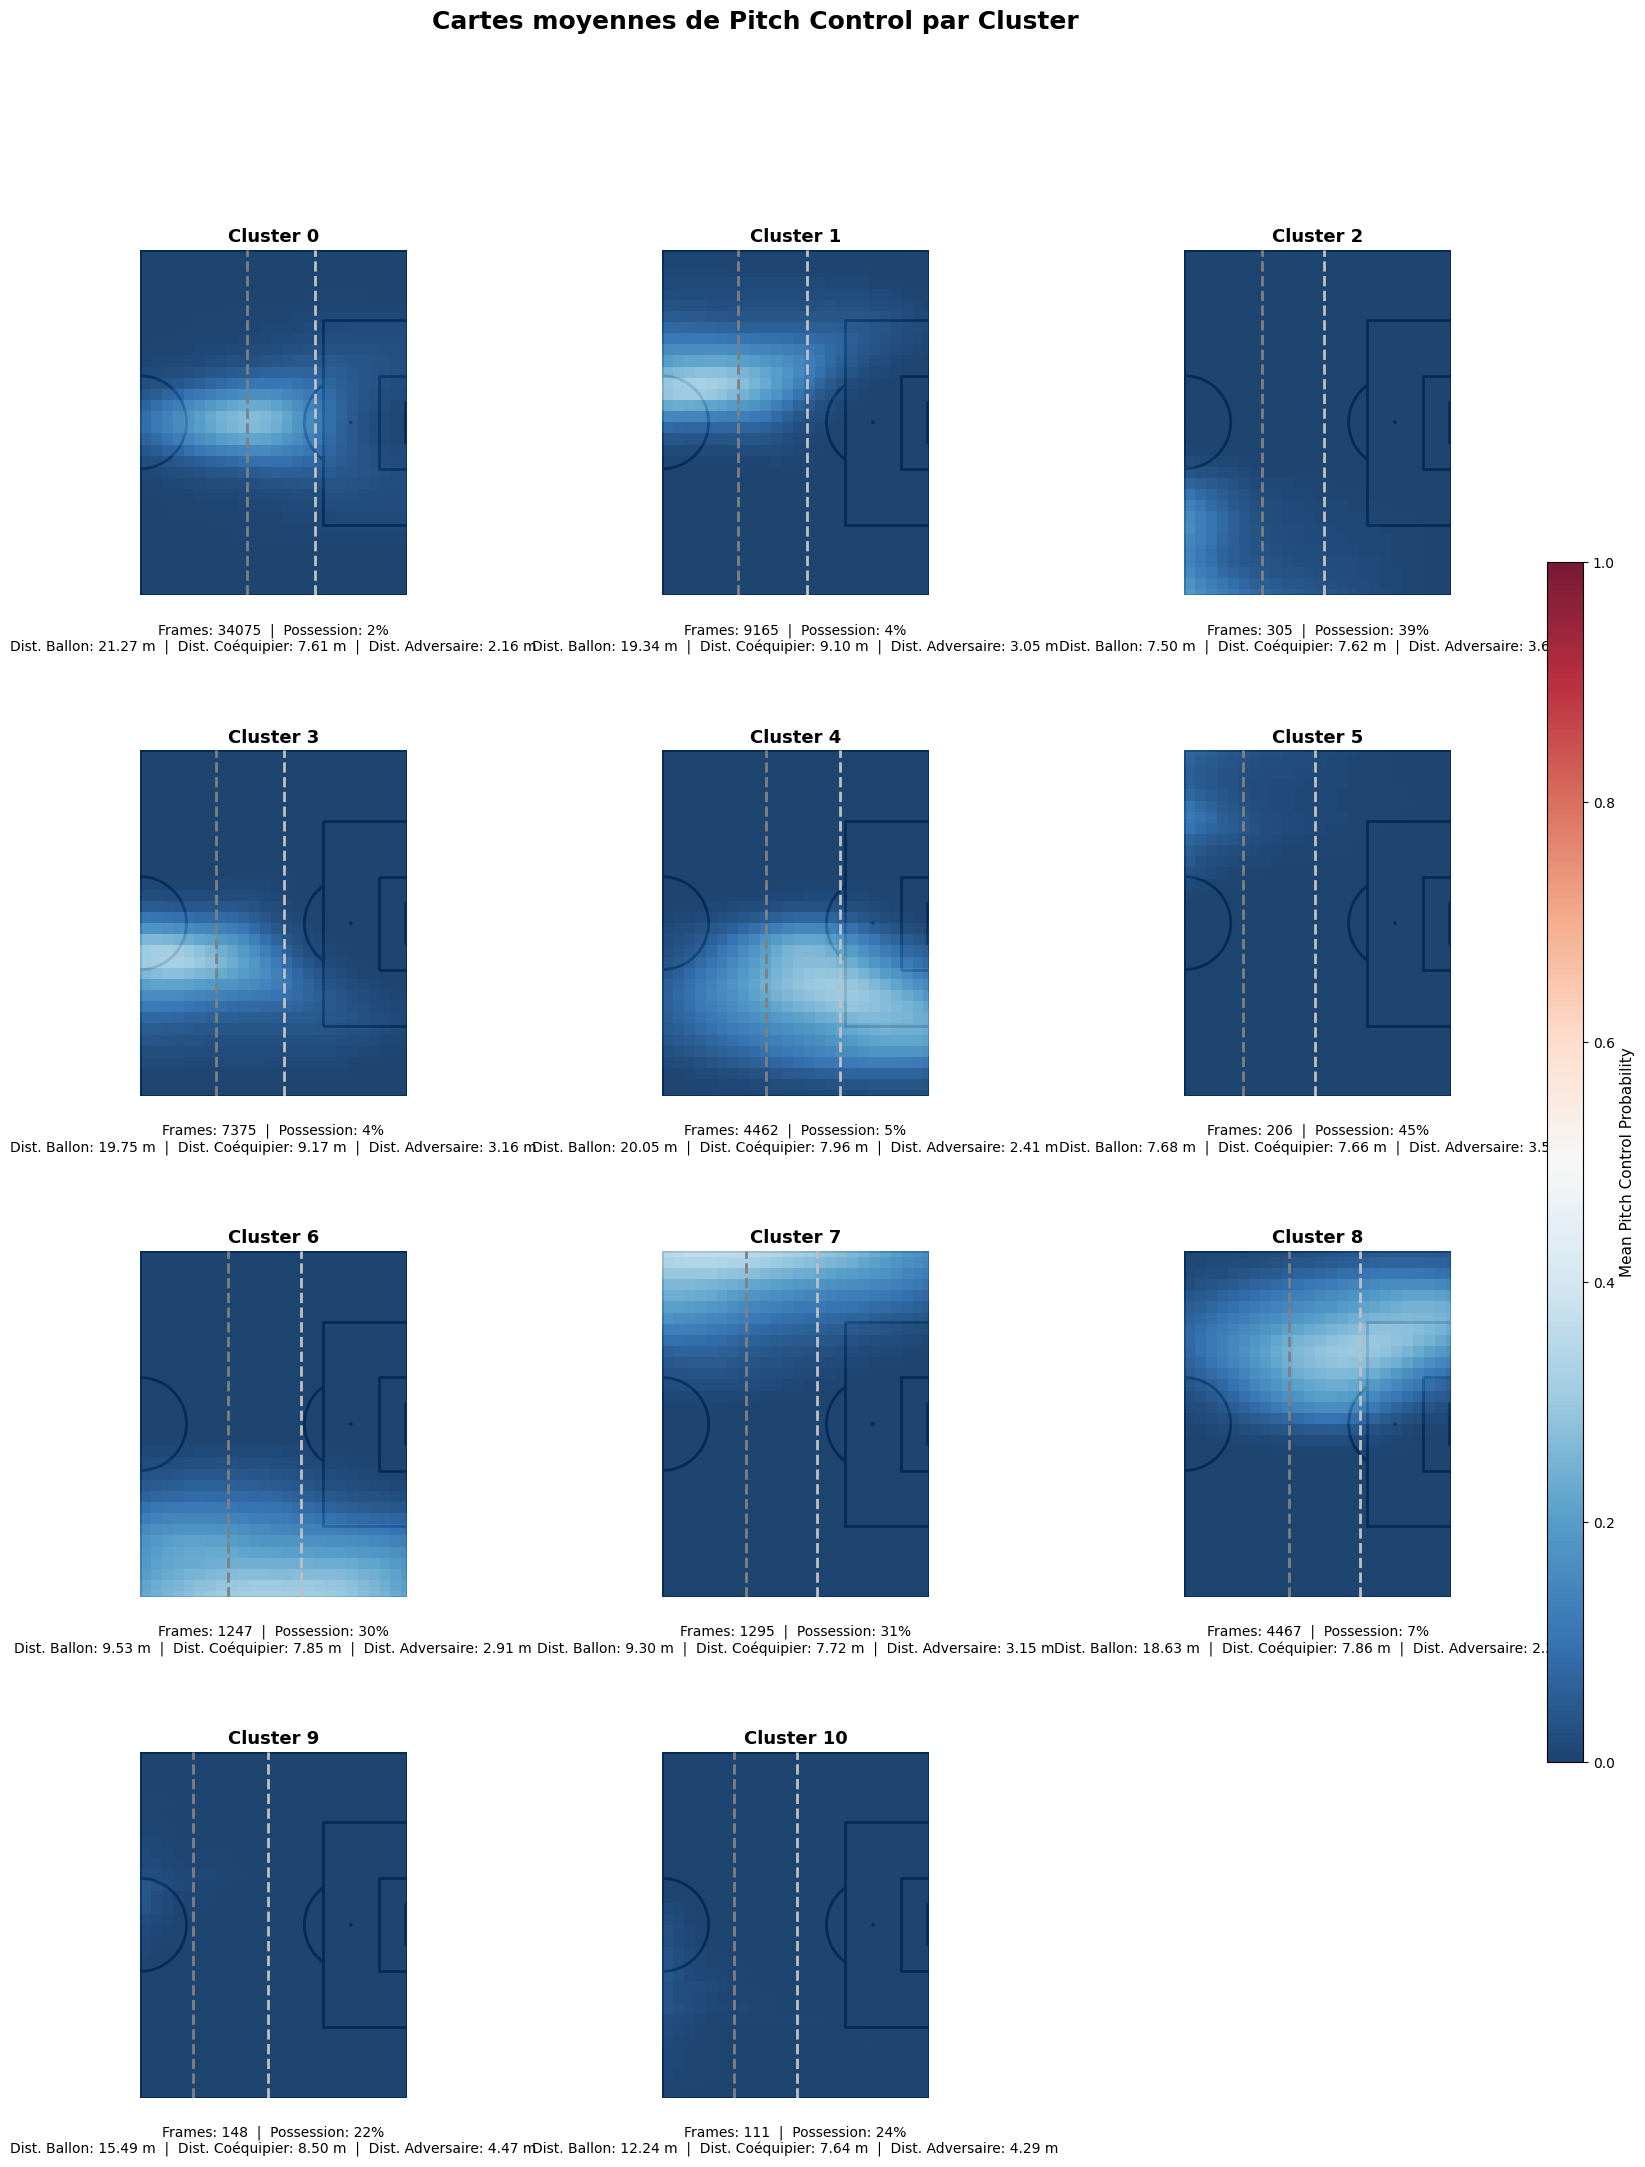

In [153]:
plot_cluster_summary_pitch_control_with_pitch(frames_inputs, meta, n_cols=3)

## Gather clusters

In [156]:
cluster_mapping = {
    0:0,
    1:1,
    2:2,
    3:1,
    4:3,
    5:2,
    6:4,
    7:4,
    8:3,
    9:2,
    10:2
}

meta['cluster_gathered'] = meta['cluster'].map(cluster_mapping)

In [157]:
meta

,match_id,frame,player_id,player_position_role,player_name,player_team,opponent_team,minute,cluster,cluster_gathered
0,1650385,1625,1498,Center Forward,Bruno Fernandes,Manchester United,Fulham,2,1,1
1,1650385,1648,1498,Center Forward,Bruno Fernandes,Manchester United,Fulham,2,1,1
2,1650385,1786,1498,Center Forward,Bruno Fernandes,Manchester United,Fulham,2,1,1
3,1650385,1810,1498,Center Forward,Bruno Fernandes,Manchester United,Fulham,3,7,4
4,1650385,1837,1498,Center Forward,Bruno Fernandes,Manchester United,Fulham,3,1,1
...,...,...,...,...,...,...,...,...,...,...
62851,2018580,54746,13368,Center Forward,Y. Wissa,Brentford FC,Wolverhampton Wanderers,29,0,0
62852,2018580,56507,13368,Center Forward,Y. Wissa,Brentford FC,Wolverhampton Wanderers,32,1,1
62853,2018580,56545,13368,Center Forward,Y. Wissa,Brentford FC,Wolverhampton Wanderers,32,0,0
62854,2018580,56572,13368,Center Forward,Y. Wissa,Brentford FC,Wolverhampton Wanderers,32,0,0


In [158]:
meta_path = f"{CLUSTERING_DIR}/meta_frames_center_forward_wo_outliers.parquet"
with fs.open(meta_path, "wb") as f:
    meta.to_parquet(f, index=False)

## Interpretation

In [223]:
def plot_cluster_summary_pitch_control_with_pitch(
    results,
    meta,
    n_cols=5,
    pitch_length=105,
    pitch_width=68,
    half_pitch=True
):
    """
    Affiche la carte moyenne de pitch control et les features contextuelles moyennes 
    uniquement pour certains clusters, avec infos globales basées sur cluster_gathered.
    """

    # --- Clusters à afficher ---
    clusters_to_display = [0, 1, 8, 7, 5]
    meta = meta.copy()

    n_clusters = len(clusters_to_display)
    n_rows = int(np.ceil(n_clusters / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows))
    axes = axes.flatten()

    cmap = plt.cm.RdBu_r
    cmap.set_bad(color="white")
    pcm = None

    total_frames = len(meta)  # total de frames toutes confondues

    for i, cluster_id in enumerate(clusters_to_display):
        ax = axes[i]

        # ---- Frames du cluster actuel ----
        cluster_indices = meta.index[meta["cluster"] == cluster_id].tolist()
        cluster_items = [results[idx] for idx in cluster_indices]

        if len(cluster_items) == 0:
            ax.axis("off")
            continue

        # ---- Moyenne des cartes de pitch control ----
        maps = np.array([item["pitch_control_map"] for item in cluster_items])
        mean_map = np.nanmean(maps, axis=0)

        # ---- Moyenne des lignes défensives ----
        def_lines_list = []
        for item in cluster_items:
            lines = np.array(item.get("defensive_lines", []), dtype=float)
            if lines.size == 0:
                padded = np.array([np.nan, np.nan, np.nan])
            else:
                padded = np.pad(lines, (0, max(0, 3 - len(lines))), mode="constant", constant_values=np.nan)
            def_lines_list.append(padded)
        all_lines = np.vstack(def_lines_list)
        mean_lines = np.nanmean(all_lines, axis=0)

        # ---- Moyennes des features contextuelles ----
        def nanmean_safe(lst):
            arr = np.array(lst, dtype=float)
            if np.all(np.isnan(arr)):
                return np.nan
            return float(np.nanmean(arr))

        mean_dist_ball = nanmean_safe([item.get("distance_to_ball", np.nan) for item in cluster_items])
        mean_dist_tm = nanmean_safe([item.get("distance_to_nearest_teammate", np.nan) for item in cluster_items])
        mean_dist_op = nanmean_safe([item.get("distance_to_nearest_opponent", np.nan) for item in cluster_items])

        in_poss_array = np.array([1.0 if item.get("in_possession", False) else 0.0 for item in cluster_items])
        possession_ratio = float(np.nanmean(in_poss_array)) if in_poss_array.size > 0 else np.nan

        # ---- Nombre de frames total du cluster regroupé ----
        cluster_gathered_id = meta.loc[meta["cluster"] == cluster_id, "cluster_gathered"].iloc[0]
        total_frames_gathered = (meta["cluster_gathered"] == cluster_gathered_id).sum()
        ratio_frames = total_frames_gathered / total_frames

        # ---- Création du pitch ----
        pitch = Pitch(
            pitch_type="custom",
            pitch_length=pitch_length,
            pitch_width=pitch_width,
            line_color="black",
            pitch_color="white"
        )

        H, W = mean_map.shape
        x = np.linspace(0, pitch_length, W)
        y = np.linspace(0, pitch_width, H)
        bin_statistic = dict(statistic=mean_map, x_grid=x, y_grid=y)

        pitch.draw(ax=ax)
        pcm = pitch.heatmap(
            bin_statistic,
            ax=ax,
            cmap=cmap,
            vmin=0,
            vmax=1,
            alpha=0.9,
        )

        if half_pitch:
            ax.set_xlim(pitch_length / 2, pitch_length)
            ax.set_ylim(0, pitch_width)

        # ---- Lignes défensives ----
        if mean_lines.size > 0 and not np.all(np.isnan(mean_lines)):
            colors = ["black", "gray", "silver"]
            for j, x_mean in enumerate(mean_lines):
                if not np.isnan(x_mean):
                    ax.axvline(x=float(x_mean), color=colors[j % len(colors)], linestyle="--", linewidth=2)

        # ---- Formatage du texte ----
        def fmt(v):
            return f"{v:.2f}" if (v is not None and not np.isnan(v)) else "n/a"

        stats_text = (
            f"Share of total frames : ({ratio_frames:.1%})\n"
            f"Possession ratio : {possession_ratio:.0%}\n"
            f"Avg ball distance : {fmt(mean_dist_ball)} m\n"
            f"Avg closest teammate distance : {fmt(mean_dist_tm)} m\n"
            f"Avg closest opponent distance : {fmt(mean_dist_op)} m"
        )

        ax.set_title(f"Cluster {i}", fontsize=13, fontweight="bold")
        ax.text(0.5, -0.05, stats_text, transform=ax.transAxes,
                fontsize=15, ha="center", va="top", linespacing=1.6)

    # ---- Supprimer les axes vides ----
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.subplots_adjust(right=0.92, wspace=0.35, hspace=0.6)

    # ---- Barre de couleur globale ----
    if pcm is not None:
        cbar_ax = fig.add_axes([0.94, 0.05, 0.01, 0.7])
        cbar = fig.colorbar(pcm, cax=cbar_ax)
        cbar.set_label("Mean Pitch Control Probability", fontsize=11)

    #fig.suptitle("Cartes moyennes de Pitch Control (Clusters sélectionnés)", fontsize=18, fontweight="bold")
    plt.show()

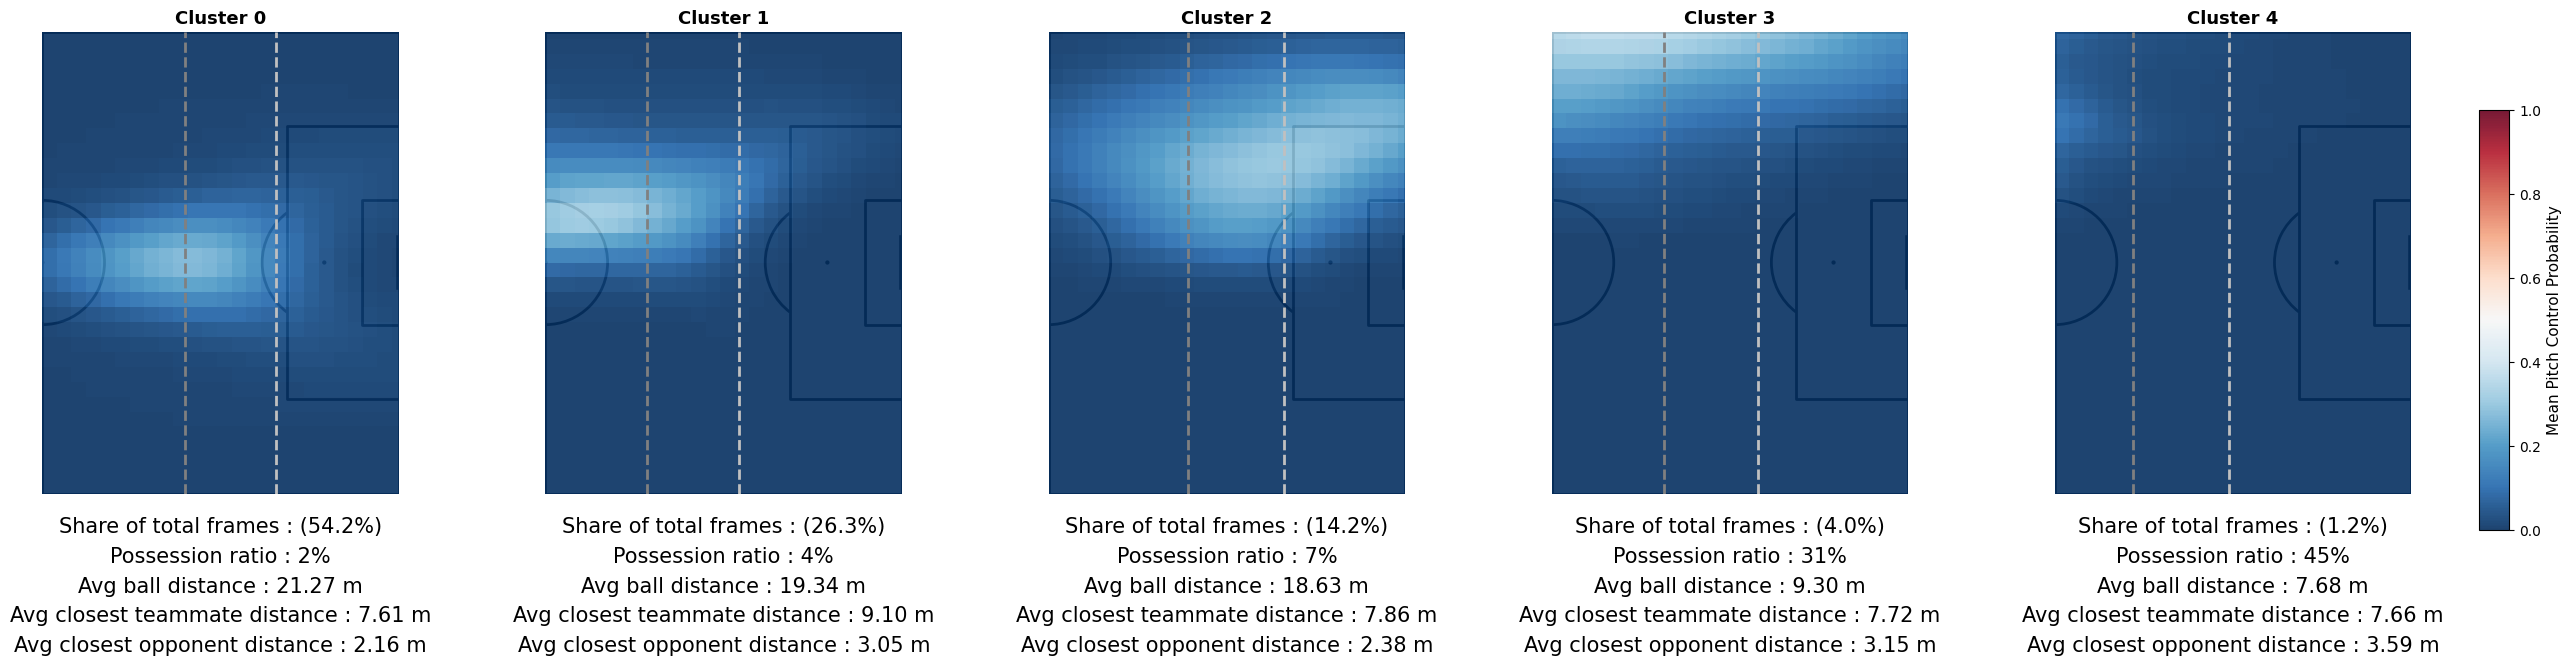

In [224]:
plot_cluster_summary_pitch_control_with_pitch(
    results=frames_inputs,
    meta=meta
)

In [225]:
def plot_representative_frames_for_cluster(
    cluster_id,
    X_embedded,
    meta,
    results,
    n_representatives=3,
    pitch_length=105,
    pitch_width=68,
    half_pitch=True
):
    """
    Affiche les n_representatives frames les plus proches du centroïde du cluster donné.
    Montre aussi les lignes défensives et les infos contextuelles sous chaque frame.
    
    Paramètres
    ----------
    cluster_id : int
        Identifiant du cluster à afficher.
    X_embedded : np.ndarray
        Embeddings (UMAP ou PCA) utilisés pour le clustering. shape=(n_frames, n_dim)
    meta : pd.DataFrame
        Métadonnées alignées avec X_embedded (doit contenir 'cluster').
    results : list
        Liste de dictionnaires correspondant à chaque frame.
    n_representatives : int
        Nombre de frames les plus représentatives à afficher.
    pitch_length, pitch_width : float
        Dimensions du terrain.
    half_pitch : bool
        Si True, n'affiche que la moitié offensive du terrain.
    """
    # --- Sélection des frames du cluster ---
    cluster_mask = (meta["cluster"] == cluster_id)
    cluster_indices = np.where(cluster_mask)[0]
    if len(cluster_indices) == 0:
        print(f"Aucun frame trouvé pour le cluster {cluster_id}.")
        return
    
    X_cluster = X_embedded[cluster_indices]

    # --- Approximation du centroïde (moyenne des embeddings du cluster) ---
    centroid = X_cluster.mean(axis=0, keepdims=True)

    # --- Distance à ce centroïde ---
    distances = pairwise_distances(X_cluster, centroid).flatten()
    top_indices = np.argsort(distances)[:n_representatives]
    representative_indices = cluster_indices[top_indices]

    # --- Setup du plot ---
    fig, axes = plt.subplots(1, n_representatives, figsize=(6 * n_representatives, 6))
    if n_representatives == 1:
        axes = [axes]

    pitch = Pitch(
        pitch_type="custom",
        pitch_length=pitch_length,
        pitch_width=pitch_width,
        line_color="black",
        pitch_color="white"
    )

    cmap = plt.cm.RdBu_r
    cmap.set_bad(color="white")

    # --- Boucle sur les frames représentatives ---
    for i, idx in enumerate(representative_indices):
        ax = axes[i]
        frame_data = results[idx]

        # --- Pitch control map ---
        pc_map = frame_data["pitch_control_map"]
        
        #pc_map_test = pc_map.flatten()
        #print(np.count_nonzero(pc_map_test))
        #print(np.sum(pc_map_test > 0.5))
        #print(np.sum(pc_map_test > 0.1))
        
        H, W = pc_map.shape
        x = np.linspace(0, pitch_length, W)
        y = np.linspace(0, pitch_width, H)
        bin_statistic = dict(statistic=pc_map, x_grid=x, y_grid=y)

        pitch.draw(ax=ax)
        pcm = pitch.heatmap(bin_statistic, ax=ax, cmap=cmap, vmin=0, vmax=1, alpha=0.9)

        if half_pitch:
            ax.set_xlim(pitch_length / 2, pitch_length)
            ax.set_ylim(0, pitch_width)

        # --- Lignes défensives ---
        def_lines = np.array(frame_data.get("defensive_lines", []), dtype=float)
        if def_lines.size > 0:
            colors = ["black", "gray", "silver"]
            for j, x_line in enumerate(def_lines[:3]):  # max 3 lignes
                ax.axvline(x=float(x_line), color=colors[j % len(colors)], linestyle="--", linewidth=2)

        # --- Informations contextuelles ---
        def fmt(v):
            return f"{v:.2f}" if v is not None and not np.isnan(v) else "n/a"

        dist_ball = frame_data.get("distance_to_ball", np.nan)
        dist_tm = frame_data.get("distance_to_nearest_teammate", np.nan)
        dist_op = frame_data.get("distance_to_nearest_opponent", np.nan)
        in_poss = "✅" if frame_data.get("in_possession", False) else "❌"

        # --- Infos depuis meta ---
        frame_id = meta.loc[idx, "frame"]
        time_min = meta.loc[idx, "minute"]
        player = meta.loc[idx, "player_name"]
        team = meta.loc[idx, "player_team"]

        # --- Titre au-dessus et texte en-dessous ---
        ax.set_title(
            f"Cluster {cluster_id} | Frame {frame_id}\n{team} - {player}\nMinute {time_min}",
            fontsize=12, fontweight="bold"
        )

        stats_text = (
            f"Possession: {in_poss}  |  Dist. Ballon: {fmt(dist_ball)} m\n"
            f"Dist. Coéquipier: {fmt(dist_tm)} m  |  Dist. Adversaire: {fmt(dist_op)} m"
        )
        ax.text(0.5, -0.12, stats_text, transform=ax.transAxes,
                fontsize=10, ha="center", va="top", wrap=True)

    plt.suptitle(f"Frames les plus représentatives du cluster {cluster_id}", fontsize=16, fontweight="bold")
    plt.tight_layout()
    plt.show()

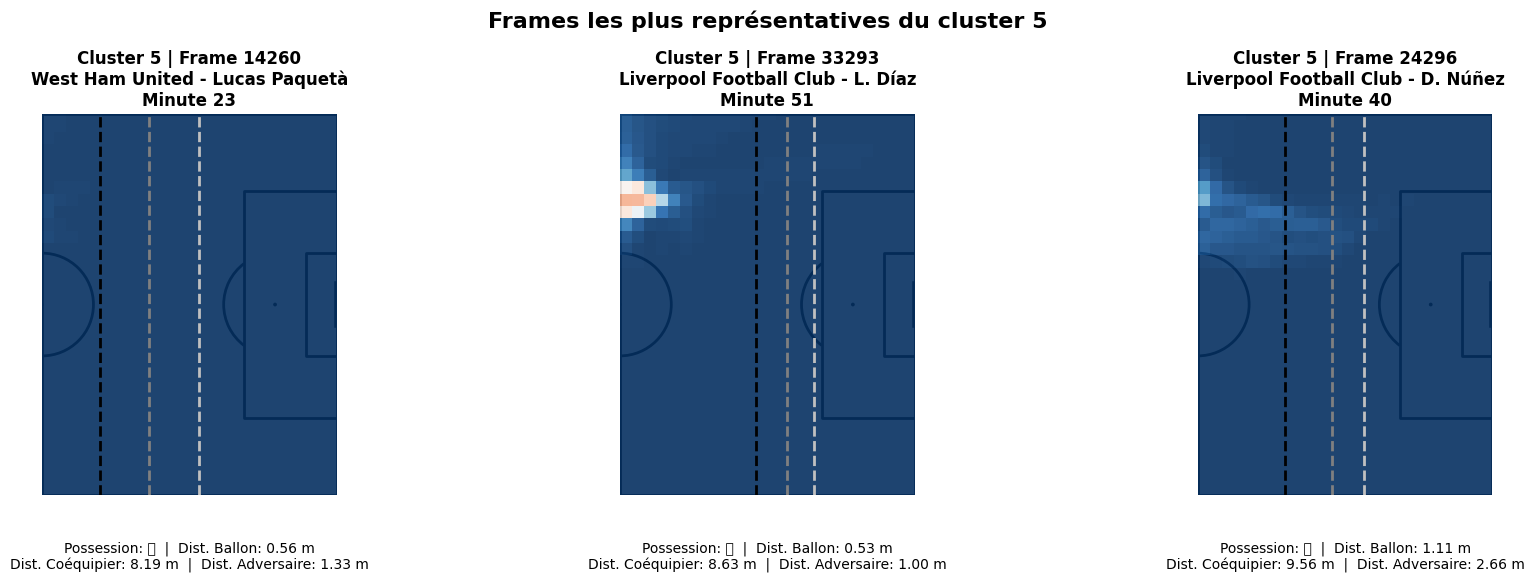

In [235]:
plot_representative_frames_for_cluster(
    cluster_id=5,
    X_embedded=X_reduced,
    meta=meta,
    results=frames_inputs,
    n_representatives=3
)

# Analysis plots

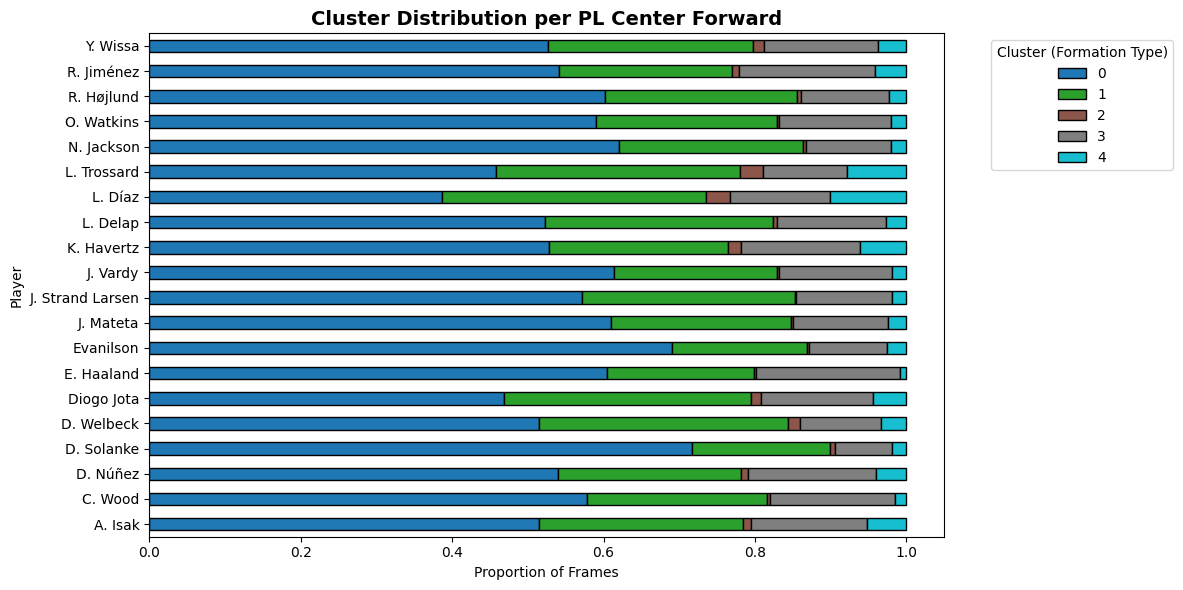

In [231]:
player_counts = meta['player_name'].value_counts().head(20)
top_players = player_counts.index

# 2️⃣ Filtrer le DataFrame pour ne garder que ces 10 joueurs
df_top = meta[meta['player_name'].isin(top_players)]

# 3️⃣ Calculer la répartition des clusters par joueur
cluster_distribution = (
    df_top.groupby(['player_name', 'cluster_gathered'])
    .size()
    .unstack(fill_value=0)
)

# 4️⃣ Normaliser en proportion pour chaque joueur
cluster_distribution = cluster_distribution.div(cluster_distribution.sum(axis=1), axis=0)

# 5️⃣ Création du graphique
ax = cluster_distribution.plot(
    kind='barh',
    stacked=True,
    figsize=(12, 6),
    colormap='tab10',
    edgecolor='black'
)

plt.title("Cluster Distribution per PL Center Forward", fontsize=14, weight='bold')
plt.xlabel("Proportion of Frames")
plt.ylabel("Player")

# Légende propre
plt.legend(
    title="Cluster (Formation Type)",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.tight_layout()
plt.show()

In [255]:
def plot_clusters_examples_for_player(
    meta: pd.DataFrame,
    player_name: str,
    match_id: str,
    pitch_length: float = 105,
    pitch_width: float = 68,
    random_state: int = 42
):
    """
    Affiche un subplot par cluster pour un joueur donné dans un match donné.
    Chaque plot représente une frame aléatoire appartenant à ce cluster,
    avec la position du joueur et celles des adversaires.

    Parameters
    ----------
    meta : pd.DataFrame
        DataFrame contenant player_name, player_id, match_id, cluster_gathered, frame
    player_name : str
        Nom du joueur à afficher
    match_id : str
        Identifiant du match
    POSSESSION_DIR : str
        Dossier contenant les fichiers parquet des positions (un fichier par match_id)
    fs : fsspec filesystem
        Pour ouvrir les fichiers distants (comme ton S3 ou GCS)
    """
    
    fs = gcsfs.GCSFileSystem()

    # --- 1️⃣ Filtrer meta pour le joueur et le match ---
    meta_match = meta[(meta["match_id"] == match_id) & (meta["player_name"] == player_name)]
    if meta_match.empty:
        print(f"Aucune donnée trouvée pour {player_name} dans le match {match_id}")
        return

    player_id = meta_match["player_id"].iloc[0]
    clusters = sorted(meta_match["cluster_gathered"].unique())
    random.seed(random_state)

    # --- 2️⃣ Charger le parquet POSSESSION ---
    possession_path = f"{POSSESSION_DIR}/{match_id}.parquet"
    try:
        with fs.open(possession_path, "rb") as fp:
            possession_df = pd.read_parquet(fp)
    except Exception as e:
        print(f"❌ Impossible de charger le fichier possession {possession_path}: {e}")
        return

    # --- 3️⃣ Identifier team_id du joueur et celui de l'adversaire ---
    team_ids = possession_df["team_id"].unique()
    player_team_id = possession_df.loc[possession_df["player_id"] == player_id, "team_id"].iloc[0]
    opponent_team_id = [tid for tid in team_ids if tid != player_team_id][0]

    # --- 4️⃣ Préparer les subplots ---
    n_clusters = len(clusters)
    fig, axes = plt.subplots(1, n_clusters, figsize=(4.5 * n_clusters, 6))
    if n_clusters == 1:
        axes = [axes]

    pitch = Pitch(pitch_type='custom', pitch_length=pitch_length, pitch_width=pitch_width,
                  line_color='black', pitch_color='white')

    # --- 5️⃣ Boucle sur les clusters ---
    for ax, cluster_id in zip(axes, clusters):
        cluster_data = meta_match[meta_match["cluster_gathered"] == cluster_id]

        # proportion du cluster dans le match
        cluster_prop = len(cluster_data) / len(meta_match)

        # frame aléatoire
        frame = cluster_data["frame"].sample(1, random_state=random.randint(0, 10000)).iloc[0]

        # positions adverses à cette frame
        opp_positions = possession_df[
            (possession_df["team_id"] == opponent_team_id) & (possession_df["frame"] == frame)
        ]

        # position du joueur
        player_pos = possession_df[
            (possession_df["player_id"] == player_id) & (possession_df["frame"] == frame)
        ]

        # --- Tracé du terrain ---
        pitch.draw(ax=ax)
        ax.set_title(f"Cluster {cluster_id}", fontsize=13, weight="bold")
        ax.text(pitch_length / 2, -5,
                f"Proportion: {cluster_prop:.1%}",
                ha="center", fontsize=15, color="gray")

        # --- Tracé du joueur ---
        if not player_pos.empty:
            px, py = float(player_pos["x_norm"]), float(player_pos["y_norm"])
            pitch.scatter(px, py, s=200, c='red', marker='*', ax=ax,
                          edgecolors='black', linewidth=1.2, zorder=10)

        # --- Tracé des adversaires ---
        if not opp_positions.empty:
            ox = opp_positions["x_norm"].values
            oy = opp_positions["y_norm"].values
            pitch.scatter(ox, oy, s=70, c='blue', ax=ax,
                          edgecolors='black', linewidth=0.5, zorder=9)

        ax.set_xlim(0, pitch_length)
        ax.set_ylim(0, pitch_width)

    plt.suptitle(f"{player_name} — Match {match_id}", fontsize=15, weight="bold")
    plt.tight_layout()
    plt.show()

/var/tmp/ipykernel_307438/1013799928.py:92: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  px, py = float(player_pos["x_norm"]), float(player_pos["y_norm"])


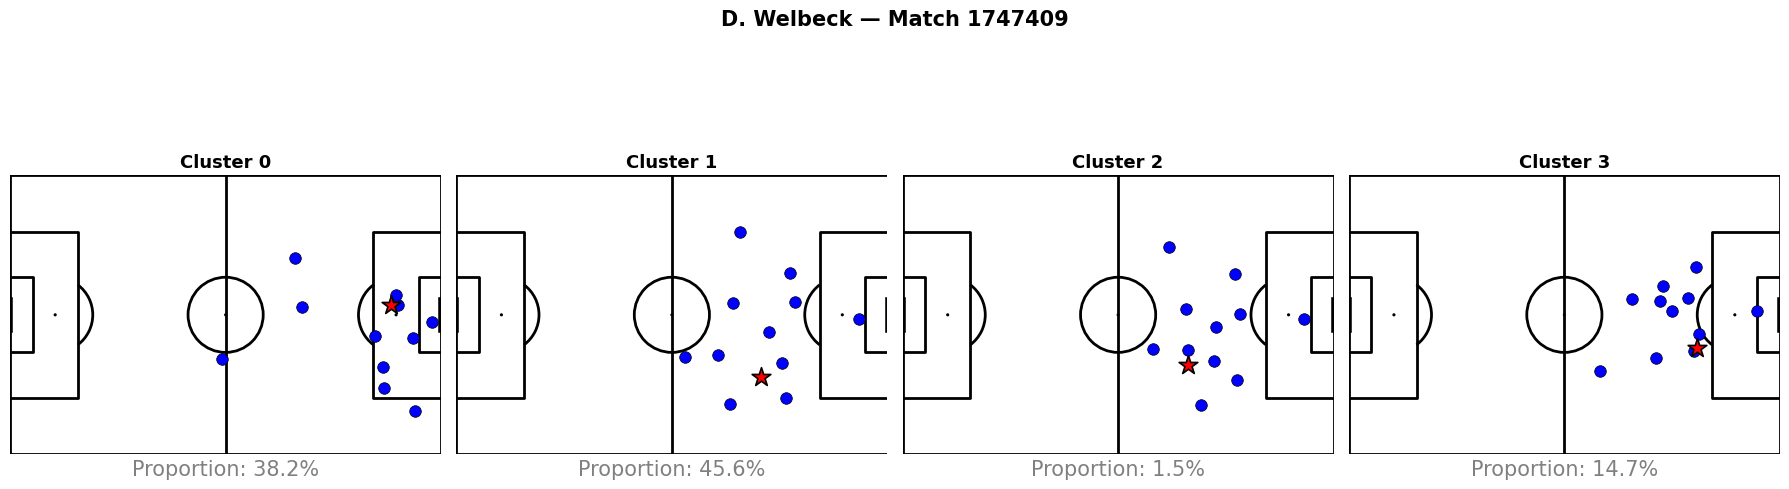

In [256]:
plot_clusters_examples_for_player(
    meta=meta,
    player_name="D. Welbeck",
    match_id="1747409",
    random_state=9
)

In [247]:
 meta[(meta["match_id"] == "2011442") & (meta["player_name"] == "A. Isak")]

,match_id,frame,player_id,player_position_role,player_name,player_team,opponent_team,minute,cluster,cluster_gathered
52611,2011442,384,12750,Center Forward,A. Isak,Newcastle United,Manchester United,0,3,1
52612,2011442,406,12750,Center Forward,A. Isak,Newcastle United,Manchester United,0,0,0
52613,2011442,449,12750,Center Forward,A. Isak,Newcastle United,Manchester United,0,0,0
52614,2011442,7530,12750,Center Forward,A. Isak,Newcastle United,Manchester United,12,8,3
52615,2011442,7569,12750,Center Forward,A. Isak,Newcastle United,Manchester United,12,0,0
...,...,...,...,...,...,...,...,...,...,...
52724,2011442,46728,12750,Center Forward,A. Isak,Newcastle United,Manchester United,15,0,0
52725,2011442,46736,12750,Center Forward,A. Isak,Newcastle United,Manchester United,15,0,0
52726,2011442,46759,12750,Center Forward,A. Isak,Newcastle United,Manchester United,15,0,0
52727,2011442,46778,12750,Center Forward,A. Isak,Newcastle United,Manchester United,15,0,0


In [266]:
def plot_cluster_distribution(df, player_name, match_id):
    # Filtrer pour le player et le match
    df_player = df[(df['player_name'] == player_name) & (df['match_id'] == match_id)].copy()
    
    # Définir les bins et labels
    bins = [0, 15, 30, 45]
    labels = ['0-15','15-30','30-45']
    
    # Ajouter la colonne de bin
    df_player['minute_bin'] = pd.cut(df_player['minute'], bins=bins, labels=labels, right=False)
    
    # Compter les clusters par bin
    cluster_counts = df_player.groupby(['minute_bin', 'cluster_gathered']).size().unstack(fill_value=0)
    
    # Plot
    cluster_counts.plot(kind='bar', width=0.8)
    plt.xlabel('Minute bin')
    plt.ylabel('Number of frames')
    plt.title(f'Share of clusters for {player_name} during 1st half against Chelsea')
    plt.xticks(rotation=0)
    plt.legend(title='Cluster')
    plt.show()

/var/tmp/ipykernel_307438/735048314.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_counts = df_player.groupby(['minute_bin', 'cluster_gathered']).size().unstack(fill_value=0)


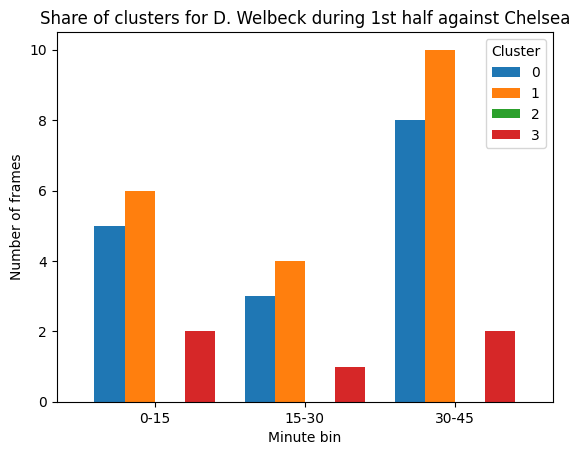

In [267]:
plot_cluster_distribution(meta, player_name="D. Welbeck", match_id="1747409")

# Apply soccermaps predictions

In [6]:
meta_path = f"{CLUSTERING_DIR}/meta_frames_center_forward_wo_outliers.parquet"

In [7]:
def read_parquet_gcs(fs: gcsfs.GCSFileSystem, gcs_path: str) -> pd.DataFrame:
    if not fs.exists(gcs_path):
        raise FileNotFoundError(gcs_path)
    # open as file-like and let pandas/pyarrow read
    with fs.open(gcs_path, "rb") as f:
        return pd.read_parquet(f)

In [9]:
meta = read_parquet_gcs(fs=fs, gcs_path=meta_path)

In [10]:
meta

,match_id,frame,player_id,player_position_role,player_name,player_team,opponent_team,minute,cluster,cluster_gathered
0,1650385,1625,1498,Center Forward,Bruno Fernandes,Manchester United,Fulham,2,1,1
1,1650385,1648,1498,Center Forward,Bruno Fernandes,Manchester United,Fulham,2,1,1
2,1650385,1786,1498,Center Forward,Bruno Fernandes,Manchester United,Fulham,2,1,1
3,1650385,1810,1498,Center Forward,Bruno Fernandes,Manchester United,Fulham,3,7,4
4,1650385,1837,1498,Center Forward,Bruno Fernandes,Manchester United,Fulham,3,1,1
...,...,...,...,...,...,...,...,...,...,...
62851,2018580,54746,13368,Center Forward,Y. Wissa,Brentford FC,Wolverhampton Wanderers,29,0,0
62852,2018580,56507,13368,Center Forward,Y. Wissa,Brentford FC,Wolverhampton Wanderers,32,1,1
62853,2018580,56545,13368,Center Forward,Y. Wissa,Brentford FC,Wolverhampton Wanderers,32,0,0
62854,2018580,56572,13368,Center Forward,Y. Wissa,Brentford FC,Wolverhampton Wanderers,32,0,0


In [46]:
PITCH_LENGTH = 105
PITCH_WIDTH  = 68
GOAL_CENTER  = np.array([105.0, 34.0])
GOAL_Y_TOP    = 34 + 7.32/2
GOAL_Y_BOTTOM = 34 - 7.32/2
GOAL_X        = 105.0


# ------------------------------------------------------------
# Grid
# ------------------------------------------------------------
def create_pitch_grid(dim=(68,105)):
    H, W = dim
    y = np.linspace(0, PITCH_WIDTH, H)
    x = np.linspace(0, PITCH_LENGTH, W)
    return np.meshgrid(x, y)   # shape (H,W)

# ------------------------------------------------------------
# 6 SPARSE CHANNELS: (att: loc,vx,vy) + (def: loc,vx,vy)
# ------------------------------------------------------------
def make_sparse_player_channels(df_frame, attacking_team, defending_team, dim=(68,105)):
    H, W = dim
    att = np.zeros((3, H, W), dtype=np.float32)
    deff = np.zeros((3, H, W), dtype=np.float32)

    for _, r in df_frame.iterrows():
        if r["is_ball"]: 
            continue

        x = int(np.clip(round(r["x_rescaled"] / PITCH_LENGTH * W), 0, W - 1))
        y = int(np.clip(round(r["y_rescaled"] / PITCH_WIDTH  * H), 0, H - 1))

        vx, vy = r.get("vx_mps", 0.0), r.get("vy_mps", 0.0)

        if r["team_short"] == attacking_team:
            att[0, y, x] = 1
            att[1, y, x] = vx
            att[2, y, x] = vy
        else:
            deff[0, y, x] = 1
            deff[1, y, x] = vx
            deff[2, y, x] = vy

    return att, deff

# ------------------------------------------------------------
# 2 DENSE CHANNELS: distances
# ------------------------------------------------------------
def make_distance_maps(ball_pos, dim=(68,105)):
    X, Y = create_pitch_grid(dim)
    dist_ball = np.sqrt((X - ball_pos[0])**2 + (Y - ball_pos[1])**2)
    dist_goal = np.sqrt((X - GOAL_CENTER[0])**2 + (Y - GOAL_CENTER[1])**2)
    return dist_ball.astype(np.float32), dist_goal.astype(np.float32)

# ------------------------------------------------------------
# 3 DENSE CHANNELS: angle maps (sin,cos,raw)
# ------------------------------------------------------------
def make_angle_maps(dim=(68,105)):
    H, W = dim
    X, Y = create_pitch_grid(dim)  # shape (H,W)

    # Vectors from each grid point to the top/bottom posts
    top_dx = GOAL_X - X
    top_dy = GOAL_Y_TOP - Y
    bot_dx = GOAL_X - X
    bot_dy = GOAL_Y_BOTTOM - Y

    top_angle = np.arctan2(top_dy, top_dx)
    bot_angle = np.arctan2(bot_dy, bot_dx)

    angle_open = np.abs(top_angle - bot_angle)
    angle_open = np.clip(angle_open, 0, np.pi)

    sin_map = np.sin(angle_open)
    cos_map = np.cos(angle_open)

    return sin_map.astype(np.float32), cos_map.astype(np.float32), angle_open.astype(np.float32)

# ------------------------------------------------------------
# 2 SPARSE CHANNELS: sin/cos(angle between ball-carrier
#                     vel and each teammate’s vel)
# ------------------------------------------------------------
def make_velocity_angle_channels(df_frame, ball_carrier_id, dim=(68,105)):
    H, W = dim
    sin_ch = np.zeros((H, W), dtype=np.float32)
    cos_ch = np.zeros((H, W), dtype=np.float32)

    carrier = df_frame[df_frame.player_id == ball_carrier_id]
    if carrier.empty:
        return sin_ch, cos_ch

    carrier = carrier.iloc[0]
    vx_c, vy_c = carrier.get("vx_mps", 0), carrier.get("vy_mps", 0)
    norm_c = np.hypot(vx_c, vy_c)

    if norm_c < 1e-6:
        return sin_ch, cos_ch

    for _, r in df_frame.iterrows():
        if r["is_ball"] or r["player_id"] == ball_carrier_id:
            continue

        x = int(np.clip(round(r["x_rescaled"] / PITCH_LENGTH * W), 0, W - 1))
        y = int(np.clip(round(r["y_rescaled"] / PITCH_WIDTH  * H), 0, H - 1))

        vx, vy = r.get("vx_mps", 0), r.get("vy_mps", 0)
        norm_t = np.hypot(vx, vy)
        if norm_t < 1e-6:
            continue

        dot = (vx*vx_c + vy*vy_c) / (norm_c * norm_t)
        dot = np.clip(dot, -1, 1)
        ang = np.arccos(dot)

        sin_ch[y, x] = np.sin(ang)
        cos_ch[y, x] = np.cos(ang)

    return sin_ch, cos_ch


# ------------------------------------------------------------
# FULL 13-CHANNEL MAP FOR ONE FRAME
# ------------------------------------------------------------
def generate_soccer_map(df_frame, attacking_team, defending_team, ball_pos, ball_carrier_id):
    att, deff = make_sparse_player_channels(df_frame, attacking_team, defending_team)
    dist_ball, dist_goal = make_distance_maps(ball_pos)
    sin_g, cos_g, ang_g = make_angle_maps()
    sin_v, cos_v = make_velocity_angle_channels(df_frame, ball_carrier_id)

    tensor = np.stack([
        *att, *deff,
        dist_ball, dist_goal,
        sin_g, cos_g, ang_g,
        sin_v, cos_v
    ], axis=0)  # (13, 68, 105)

    return tensor.astype(np.float32)

class ToSoccerMapPassSuccessTensorFromFrame:
    """
    Convert an entire frame (23 rows: 22 players + ball) into a 13-channel SoccerMap.
    Output: (13, H, W), mask (1, H, W), target scalar.
    """

    def __init__(self, dim=(68, 105)):
        self.H, self.W = dim   # grid resolution

    def _scale_coords(self, x, y):
        """Scale real pitch coords to grid indices"""
        xi = np.clip(np.round(x / PITCH_LENGTH * self.W), 0, self.W - 1).astype(int)
        yi = np.clip(np.round(y / PITCH_WIDTH  * self.H), 0, self.H - 1).astype(int)
        return xi, yi

    def __call__(self, df_frame):
        """
        df_frame = sous-dataframe des 23 rows d’un frame.
        """
        # ---- Extract infos identical for all rows ----
        start_x = df_frame["x_start_rescaled"].iloc[0]
        start_y = df_frame["y_start_rescaled"].iloc[0]
        end_x   = df_frame["x_end_rescaled"].iloc[0]
        end_y   = df_frame["y_end_rescaled"].iloc[0]

        target = float(df_frame["label"].iloc[0])
        ball_row = df_frame[df_frame["is_ball"]].iloc[0]
        ball_pos = np.array([ball_row["x_rescaled"], ball_row["y_rescaled"]])

        ball_carrier_id = df_frame["player_in_possession_id"].iloc[0]

        # Teams
        attacking = df_frame[df_frame["player_id"] == ball_carrier_id]["team_short"].iloc[0]
        defending = df_frame[df_frame["team_short"] != attacking]["team_short"].unique()[0]

        # ---- Build channels ----
        att_ch, def_ch = make_sparse_player_channels(df_frame, attacking, defending, dim=(self.H, self.W))
        dist_ball, dist_goal = make_distance_maps(ball_pos, dim=(self.H, self.W))
        sin_goal, cos_goal, angle_goal = make_angle_maps(dim=(self.H, self.W))
        sin_vel, cos_vel = make_velocity_angle_channels(df_frame, ball_carrier_id, dim=(self.H, self.W))

        tensor = np.stack([
            *att_ch,
            *def_ch,
            dist_ball, dist_goal,
            sin_goal, cos_goal, angle_goal,
            sin_vel, cos_vel
        ], axis=0)  # (13, H, W)

        # ---- mask: 1 at end location ----
        xe, ye = self._scale_coords(end_x, end_y)
        mask = np.zeros((1, self.H, self.W), dtype=np.float32)
        mask[0, ye, xe] = 1.0

        return (
            torch.tensor(tensor, dtype=torch.float32),
            torch.tensor(mask, dtype=torch.float32),
            torch.tensor([target], dtype=torch.float32),
        )

In [20]:
import torch
import torch.nn as nn
import torchmetrics
import pytorch_lightning as pl
import tempfile

class SoccerMap(nn.Module):
    def __init__(self, in_channels=13):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.GroupNorm(1, 32),  # remplace BatchNorm2d
            nn.ReLU(),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.GroupNorm(1, 64),
            nn.ReLU()
        )
        self.head = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        x = torch.clamp(x, -1.0, 1.0)
        x = self.encoder(x)
        x = self.head(x)
        return x  # [B, 1, H, W]

class PytorchSoccerMapModel(pl.LightningModule):
    def __init__(self, lr=1e-4):
        super().__init__()
        self.save_hyperparameters() # saves lr=1e-4 automatically, so it’s logged and checkpointed.

        # --- Core SoccerMap CNN ---
        self.model = SoccerMap(in_channels=13)

        # --- Loss & Metrics ---
        self.criterion = nn.BCEWithLogitsLoss() # The main training objective — compares predictions vs. true labels (0 or 1). It’s a binary cross-entropy loss that expects raw outputs (logits) from the model.
        self.train_acc = torchmetrics.classification.BinaryAccuracy() # How often the model’s prediction is correct (above or below 0.5).
        self.train_auc = torchmetrics.classification.BinaryAUROC() # Measures how well the model ranks positives above negatives — more robust than accuracy for imbalanced data.
        self.val_acc = torchmetrics.classification.BinaryAccuracy()
        self.val_auc = torchmetrics.classification.BinaryAUROC()
        
    def on_train_start(self):
        print(f"🚀 Training on device: {self.device}")
        # Si tu veux logguer la mémoire GPU :
        if self.device.type == "cuda":
            print(f"🔋 GPU memory allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

    def forward(self, x):
        """Forward pass through CNN to get full surface logits. “To make a prediction, pass the input x through the CNN.”"""
        return self.model(x)  # [B, 1, 68, 105]

    def shared_step(self, batch, stage="train"):
        x, mask, y = batch
        logits = self(x)  # [B, 1, 68, 105] runs the CNN to produce the surface logits (raw values before sigmoid).

        # --- Apply mask to reduce spatial logits to one scalar per sample ---
        masked_logits = (logits * mask).sum(dim=(2, 3))  # [B, 1]
        """extracts only the predicted value at the pass destination cell.
        The rest of the pitch is ignored (set to zero).
        The sum effectively collapses the spatial surface into a single scalar prediction per sample.
        So now you’ve gone from [B, 1, 68, 105] → [B, 1]."""

        # --- Compute loss ---
        loss = self.criterion(masked_logits, y)

        # --- Compute metrics ---
        probs = torch.sigmoid(masked_logits) # sigmoid converts raw numbers into probabilities (0–1 range).
        acc = self.train_acc(probs, y.int()) if stage == "train" else self.val_acc(probs, y.int())
        auc = self.train_auc(probs, y.int()) if stage == "train" else self.val_auc(probs, y.int())

        # --- Logging ---
        self.log(f"{stage}/loss", loss, prog_bar=True, on_epoch=True)
        self.log(f"{stage}/acc", acc, prog_bar=True, on_epoch=True)
        self.log(f"{stage}/auc", auc, prog_bar=True, on_epoch=True)
        """Lightning handles logging automatically — these values will appear in your progress bar and epoch summaries."""

        return loss

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, stage="train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, stage="val")
    
    def on_train_epoch_end(self):
        loss = self.trainer.callback_metrics.get("train/loss_epoch")
        acc = self.trainer.callback_metrics.get("train/acc_epoch")
        auc = self.trainer.callback_metrics.get("train/auc_epoch")
        print(f"🧠 Epoch {self.current_epoch} — TRAIN | loss: {loss:.4f}, acc: {acc:.4f}, auc: {auc:.4f}")

    def on_validation_epoch_end(self):
        loss = self.trainer.callback_metrics.get("val/loss")
        acc = self.trainer.callback_metrics.get("val/acc")
        auc = self.trainer.callback_metrics.get("val/auc")
        print(f"🎯 Epoch {self.current_epoch} — VAL | loss: {loss:.4f}, acc: {acc:.4f}, auc: {auc:.4f}")


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr) # The optimizer updates all model parameters based on gradients from the loss function.

In [21]:
def load_checkpoint_from_gcs(gcs_path: str, model_class: pl.LightningModule):
    """
    Télécharge un checkpoint depuis GCS vers un fichier temporaire
    puis charge le modèle Lightning.
    
    Parameters
    ----------
    gcs_path : str
        Ex: "gs://arthur_tmp/soccermap_model/best.ckpt"
    model_class : LightningModule
        La classe du modèle (ex: PytorchSoccerMapModel)

    Returns
    -------
    model : LightningModule
    """

    # 1) On crée un fichier temporaire local
    with tempfile.NamedTemporaryFile(suffix=".ckpt", delete=True) as tmp:

        # 2) Téléchargement depuis GCS vers ce fichier temp
        fs = fsspec.filesystem("gs")
        with fs.open(gcs_path, "rb") as remote_file:
            tmp.write(remote_file.read())
            tmp.flush()

        # 3) Chargement du modèle PL
        model = model_class.load_from_checkpoint(tmp.name)
        model.eval()
        return model

In [16]:
best_ckpt_path = f"{SOCCERMAP_MODELS_DIR}/best.ckpt"

In [22]:
model = load_checkpoint_from_gcs(best_ckpt_path, PytorchSoccerMapModel)
model.eval()

PytorchSoccerMapModel(
  (model): SoccerMap(
    (encoder): Sequential(
      (0): Conv2d(13, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(1, 32, eps=1e-05, affine=True)
      (2): ReLU()
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): GroupNorm(1, 64, eps=1e-05, affine=True)
      (5): ReLU()
    )
    (head): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
  )
  (criterion): BCEWithLogitsLoss()
  (train_acc): BinaryAccuracy()
  (train_auc): BinaryAUROC()
  (val_acc): BinaryAccuracy()
  (val_auc): BinaryAUROC()
)

In [40]:
match_id = 1650961
pitch_control_path = f"{PITCH_CONTROL_DIR}/{match_id}.npz"

with fs.open(pitch_control_path, "rb") as f:
    data = np.load(f, allow_pickle=True)
    results = data["results"].tolist()

In [59]:
pitch_control_path

'gs://arthur_tmp/pitch_control/1650961.npz'

In [60]:
results[0:2]

[{'pitch_control_map': array([[0.        , 0.        , 0.        , ..., 0.2457436 , 0.21857936,
          0.19213628],
         [0.        , 0.        , 0.        , ..., 0.17841331, 0.14609492,
          0.12367451],
         [0.        , 0.        , 0.        , ..., 0.09829216, 0.08602993,
          0.09908822],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ]]),
  'defensive_lines': [58.736899038461544, 72.58125, 90.01326923076924],
  'frame': 1090,
  'player_id': 32125,
  'player_position': (83.27307692307693, 10.2),
  'ball_position': (91.19855769230769, 23.42),
  'in_possession': False,
  'distance_to_ball': 15.41368370713006,
  'distance_to_nearest_teammate': 3.6598626780912507,
  'distance_to_nearest_opponent': 3.661633564991

In [55]:
results[0]['pitch_control_map'].shape

(32, 50)

In [41]:
frames_pitch_control = [results[i]['frame'] for i in range(len(results))]

In [30]:
fpath = f"{SOCCERMAP_FRAMES_DIR3}/samples_of_frames_normed.parquet"
df = read_parquet_gcs(fs, fpath).copy()

In [31]:
df.head()

,match_id,time,frame,period,player_id,is_detected,is_ball,x,y,x_rescaled,y_rescaled,time_s,vx_mps,vy_mps,speed_mps,team_id,team_name,team_short,position_group,player_role,player_short_name,is_goalkeeper,event_id,event_type,end_type,pass_outcome,player_in_possession_id,team_in_possession,team_in_possession_shortname,attacking_side,x_start_rescaled,y_start_rescaled,x_end_rescaled,y_end_rescaled,lead_to_goal,lead_to_shot,label
0,1650385,00:00:07.70,87,1,494,False,False,-10.97,-22.41,63.575481,56.41,7.7,0.471154,0.333333,0.577146,48.0,Fulham,Fulham,Wide Attacker,Left Winger,A. Iwobi,False,8_2,player_possession,pass,successful,4504,48,Fulham,right_to_left,26.956731,27.57,29.723077,13.54,False,False,1.0
1,1650385,00:00:07.70,87,1,1329,False,False,41.34,0.89,10.762500,33.11,7.7,-0.774038,-0.333333,0.842761,48.0,Fulham,Fulham,Other,Goalkeeper,B. Leno,False,8_2,player_possession,pass,successful,4504,48,Fulham,right_to_left,26.956731,27.57,29.723077,13.54,False,False,1.0
2,1650385,00:00:07.70,87,1,1498,True,False,8.69,7.75,43.726442,26.25,7.7,-5.115385,1.000000,5.212213,31.0,Manchester United,Manchester U,Center Forward,Center Forward,Bruno Fernandes,False,8_2,player_possession,pass,successful,4504,48,Fulham,right_to_left,26.956731,27.57,29.723077,13.54,False,False,1.0
3,1650385,00:00:07.70,87,1,1674,True,False,-3.34,-3.02,55.872115,37.02,7.7,-3.735577,1.066667,3.884883,31.0,Manchester United,Manchester U,Midfield,Right Defensive Midfield,Casemiro,False,8_2,player_possession,pass,successful,4504,48,Fulham,right_to_left,26.956731,27.57,29.723077,13.54,False,False,1.0
4,1650385,00:00:07.70,87,1,4504,True,False,25.30,6.43,26.956731,27.57,7.7,-1.548077,0.200000,1.560943,48.0,Fulham,Fulham,Central Defender,Right Center Back,I. Diop,False,8_2,player_possession,pass,successful,4504,48,Fulham,right_to_left,26.956731,27.57,29.723077,13.54,False,False,1.0


In [42]:
frames_soccermap = list(df[df.match_id == match_id].frame.unique())

In [43]:
list(set(frames_pitch_control) & set(frames_soccermap))

[43296, 54340, 6612, 35454, 12255]

In [47]:
from scipy.ndimage import gaussian_filter

def predict_and_plot_frame(model, df, match_id, frame, dim=(68, 105), sigma=2):
    """
    Calcule et affiche la carte de probabilité pour un match_id + frame donné.
    
    Inputs :
    - model : modèle PyTorch chargé (eval)
    - df : dataframe normalisé COMPLET (tous players + ball)
    - match_id : id du match
    - frame : index temporel
    - dim : résolution (H, W)
    - sigma : lissage heatmap
    """

    # ---------------------------
    # 1) Récupération de la frame
    # ---------------------------
    frame_df = df.query("match_id == @match_id and frame == @frame").copy()
    if frame_df.empty:
        raise ValueError(f"Frame introuvable : match_id={match_id}, frame={frame}")

    # une balle doit être présente
    if frame_df["is_ball"].sum() != 1:
        raise ValueError("Frame invalide : il doit y avoir exactement 1 ligne 'ball'.")

    # ---------------------------
    # 2) Transform → tenseur entrée modèle
    # ---------------------------
    transform = ToSoccerMapPassSuccessTensorFromFrame(dim=dim)
    x, mask, y = transform(frame_df)   # y ignoré

    x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)

    # ---------------------------
    # 3) Prédiction
    # ---------------------------
    model.eval()
    with torch.no_grad():
        logits = model(x)
        probs = torch.sigmoid(logits)[0, 0].cpu().numpy()  # (H, W)

    # lissage
    probs_smooth = gaussian_filter(probs, sigma=sigma)

    # ---------------------------
    # 4) Séparation players / ball
    # ---------------------------
    team_in_pos = frame_df["team_in_possession"].iloc[0]

    att = frame_df[(frame_df["team_id"] == team_in_pos) & ~frame_df["is_ball"]]
    defn = frame_df[(frame_df["team_id"] != team_in_pos) & ~frame_df["is_ball"]]
    ball = frame_df[frame_df["is_ball"]]

    # ---------------------------
    # 5) Plot du pitch
    # ---------------------------
    pitch = Pitch(
        pitch_type='custom',
        pitch_length=105, pitch_width=68,
        pitch_color='white',
        line_color='black'
    )
    fig, ax = pitch.draw(figsize=(10, 7))

    # heatmap
    im = ax.imshow(
        probs_smooth,
        extent=[0, 105, 0, 68],
        origin='lower',
        cmap='coolwarm',
        alpha=0.9,
        interpolation='bilinear',
        zorder=1
    )

    # ---------------------------
    # 6) Ajout players + ball
    # ---------------------------
    ax.scatter(att["x_rescaled"], att["y_rescaled"],
               s=120, c='red', edgecolors='black', linewidth=1.2, label='Attacking', zorder=3)

    ax.scatter(defn["x_rescaled"], defn["y_rescaled"],
               s=120, c='blue', edgecolors='black', linewidth=1.2, label='Defending', zorder=3)

    ax.scatter(ball["x_rescaled"], ball["y_rescaled"],
               s=150, c='white', edgecolors='black', linewidth=1.5, marker='o', label='Ball', zorder=4)

    # ---------------------------
    # 7) Vecteurs vitesse
    # ---------------------------
    arrow_scale = 0.4
    arrow_width = 0.004
    head_width = 2.5
    head_length = 3.0

    ax.quiver(att["x_rescaled"], att["y_rescaled"],
              att["vx_mps"], att["vy_mps"],
              color='darkred', angles='xy', scale_units='xy',
              scale=arrow_scale, width=arrow_width,
              headwidth=head_width, headlength=head_length, zorder=4)

    ax.quiver(defn["x_rescaled"], defn["y_rescaled"],
              defn["vx_mps"], defn["vy_mps"],
              color='navy', angles='xy', scale_units='xy',
              scale=arrow_scale, width=arrow_width,
              headwidth=head_width, headlength=head_length, zorder=4)

    if not ball.empty:
        ax.quiver(ball["x_rescaled"], ball["y_rescaled"],
                  ball["vx_mps"], ball["vy_mps"],
                  color='black', angles='xy', scale_units='xy',
                  scale=arrow_scale * 0.5, width=arrow_width * 1.2,
                  headwidth=head_width * 1.5, headlength=head_length * 1.5,
                  zorder=5)

    # ---------------------------
    # 8) Styling final
    # ---------------------------
    cbar = fig.colorbar(im, ax=ax, fraction=0.035)
    cbar.set_label('Predicted Success Probability', fontsize=11)
    ax.legend(loc='upper left', fontsize=10)

    plt.title(f"Pass Success Probability — Match {match_id}, Frame {frame}", fontsize=14)
    plt.tight_layout()
    plt.show()

    return probs_smooth

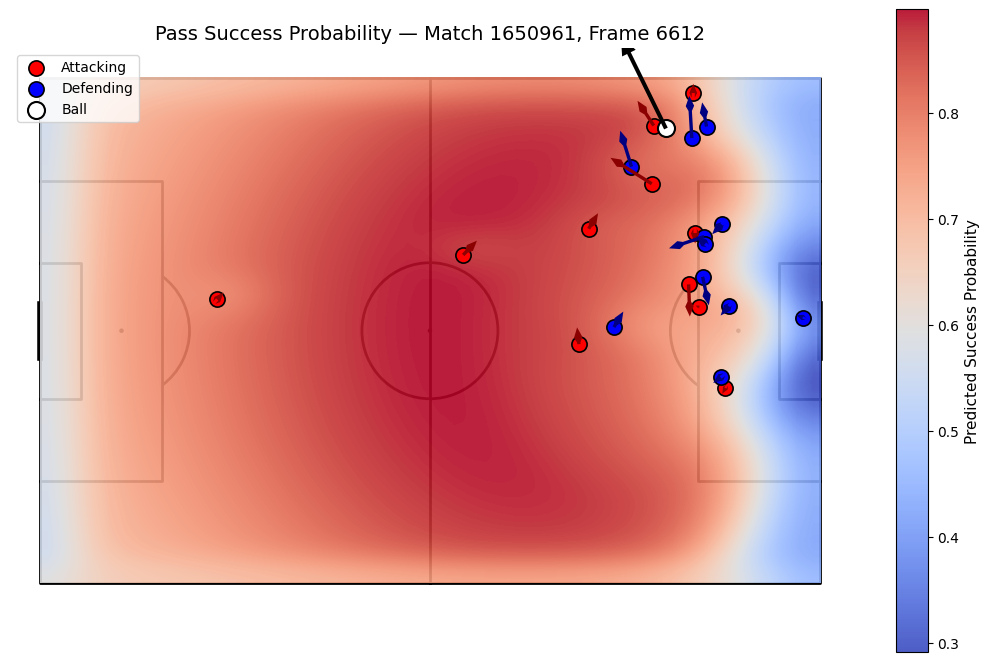

In [57]:
probs_smooth = predict_and_plot_frame(
    model=model,
    df=df,  
    match_id=match_id,
    frame=6612,
    dim=(64, 50)
)

In [58]:
probs_smooth.shape

(64, 50)

In [71]:
def predict_pass_success_with_pitch_control(
    model,
    df,
    match_id,
    frame,
    transform,
    pitch_length=105,
    pitch_width=68,
    smooth_sigma=1.5,
    half_pitch=True
):
    """
    Combine (Pass Success Model Output) × (Player Pitch Control)
    and plot on half pitch.

    Returns:
        weighted_probability : float
    """

    # -------------------------
    # 1️⃣ Extraire la frame DF
    # -------------------------
    frame_df = df[(df.match_id == match_id) & (df.frame == frame)]
    if frame_df.empty:
        raise ValueError(f"Frame {frame} not found in match {match_id}")

    # On prépare le tenseur d’entrée du modèle CNN
    x, mask, y = transform(frame_df)
    x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)

    # -------------------------
    # 2️⃣ Prédiction du modèle
    # -------------------------
    model.eval()
    with torch.no_grad():
        logits = model(x)
        probs = torch.sigmoid(logits)[0, 0].cpu().numpy()   # shape (64,50)
    probs_half_pitch = probs[-32:, :]  # shape (32,50)

    # -------------------------
    # 3️⃣ Charger le pitch control du joueur
    # -------------------------
    
    pitch_control_path = f"{PITCH_CONTROL_DIR}/{match_id}.npz"
    with fs.open(pitch_control_path, "rb") as f:
        data = np.load(f, allow_pickle=True)
        pc_result = data["results"].tolist()

    # trouver l’entrée correspondant à ce frame
    entry = next((e for e in pc_result if e["frame"] == frame), None)
    if entry is None:
        raise ValueError(f"Frame {frame} not found in pitch-control file.")

    pc_map = entry["pitch_control_map"]     # shape (32 × 50)
    player_id = entry["player_id"]
    player_x, player_y = entry["player_position"]

    # -------------------------
    # 4️⃣ Combinaison : pass_success × pitch_control
    # -------------------------
    combined = probs_half_pitch * pc_map
    combined_smooth = gaussian_filter(combined, sigma=smooth_sigma)

    # -------------------------
    # 5️⃣ Probabilité pondérée demandée
    # -------------------------
    weighted_probability = combined.sum() / (pc_map.sum() + 1e-8)

    # -------------------------
    # 6️⃣ Plot
    # -------------------------
    pitch = Pitch(
        pitch_type='custom',
        pitch_length=pitch_length,
        pitch_width=pitch_width,
        pitch_color='white',
        line_color='black'
    )

    fig, ax = pitch.draw(figsize=(10, 7))

    # Half pitch view
    if half_pitch:
        ax.set_xlim(pitch_length / 2, pitch_length)
        ax.set_ylim(0, pitch_width)

    # Heatmap combinée
    extent = [pitch_length/2, pitch_length, 0, pitch_width]

    im = ax.imshow(
        combined,
        extent=extent,
        origin='lower',
        cmap='coolwarm',
        alpha=0.9,
        interpolation='bilinear',
        zorder=1
    )

    # Player position highlight
    px, py = entry["player_position"]
    ax.scatter(px, py, s=180, c='yellow', edgecolors='black',
               linewidth=1.5, marker='o', label=f"Player {player_id}", zorder=5)

    # Ball
    bx, by = entry["ball_position"]
    ax.scatter(bx, by, s=150, c='white', edgecolors='black',
               linewidth=1.5, marker='o', label='Ball', zorder=6)

    cbar = fig.colorbar(im, ax=ax, fraction=0.035)
    cbar.set_label("PitchControl × PassSuccess", fontsize=11)

    ax.set_title(f"Match {match_id} – Frame {frame}\nPlayer {player_id}", fontsize=14)
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

    # -------------------------
    # 7️⃣ Return result
    # -------------------------
    return weighted_probability

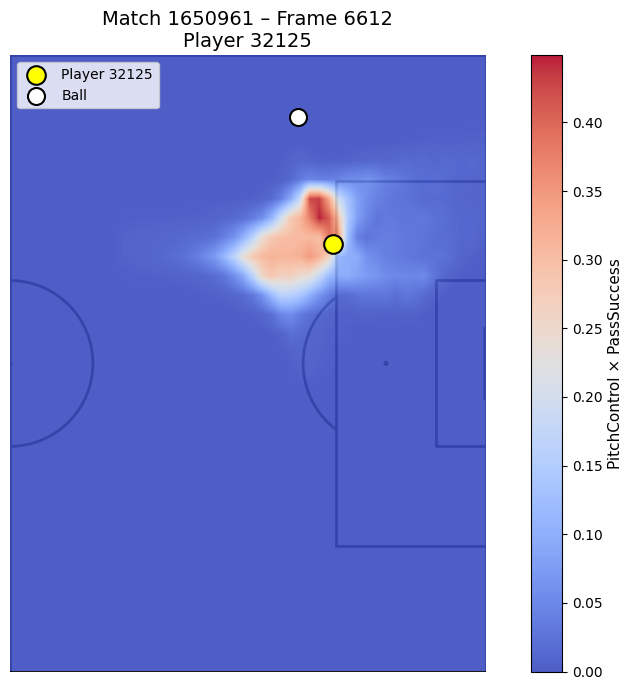

In [72]:
prob = predict_pass_success_with_pitch_control(
    model=model,
    df=df,
    match_id=match_id,
    frame=6612,
    transform=ToSoccerMapPassSuccessTensorFromFrame(dim=(64,50))
)